# SHREG notebook to improve cubes
This notebook is used to improve the final results of the semi-automated data reduction notebooks. This could involve:
 - choosing a different weighting
 - using better pixel sizes
 - clean better
 
As an input this notebook needs for every data cube that needs improvement:
 - the name of the ATCA observing project (C*)
 - a list of the observations going into the data cube
 - if need be a different weighting
 - if need be a different pixelsize
 - if need be a different velocity plane width

# Import relevant packages

In [1]:
import data_reduction_modules as drm
from mirpy import miriad
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import glob
import shutil
import sys
import numpy as np
import logging
from datetime import datetime

No handlers could be found for logger "keyring.backend"


In [2]:
def calc_column_dens(array, theta1, theta2):
    col_dens_cm2 = 1.823e18 * ((606. * array * 1000.) / (theta1*theta2)) #cm^-2
    col_dens_sun = col_dens_cm2 * 8.044e-21 #M_sun / pc^2
    return col_dens_cm2, col_dens_sun

In [3]:
def plot_moment_map(m, rad, wcs, no, levs):
    my_cmap = mpl.cm.viridis
    my_cmap.set_under('white')
    imsize = ((0.5 * rad * 60.) / (3600. * m[0].header['CDELT2']))

    fig = plt.figure(figsize=(10, 8.0))
    ax1 = fig.add_axes([0.17, 0.17, 0.65, 0.77], projection=wcs)
    ax1.set_ylim(m[0].data.shape[1] / 2 - imsize,
                 m[0].data.shape[1] / 2 + imsize)
    ax1.set_xlim(m[0].data.shape[2] / 2 - imsize,
                 m[0].data.shape[2] / 2 + imsize)
    ax1.imshow(m[0].data[0, :, :], norm=no, 
               origin='lower', cmap=my_cmap, 
               transform=ax1.get_transform(WCS(m[0].header).dropaxis(2)))
    lon, lat = ax1.coords[0], ax1.coords[1]
    lon.set_major_formatter('hh:mm:ss.s')
    lat.set_major_formatter('dd:mm')
    lon.set_ticklabel(exclude_overlapping=True)
    lat.set_ticklabel(exclude_overlapping=True)
    ax1.set_xlabel('RA')
    ax1.set_ylabel('Dec')
    
    cb_axes = [0.87, 0.17, 0.03, 0.77]
    ax2 = fig.add_axes(cb_axes)
    cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=my_cmap, norm=no)
    cb2.set_label('N$\mathrm{_{HI}}$ [M$_{\odot}$ pc$^{-2}$]', fontsize=8)
    cb2.ax.tick_params(labelsize=8)

In [4]:
def get_cube_info(m):
    for i in range(len(m[0].header['history'])):
        his = m[0].header['history'][i]
        if his[ : 15] == 'INVERT:   cell=':
            cell_size = his.split('=')[1]
        elif his[ : 15] == 'INVERT:   robus':
            robust = his.split('=')[1]
        elif his[ : 15] == 'INVERT:   line=':
            line = his.split('=')[1]
    print('The current cell is {0} arcsec.'.format(cell_size)) 
    print('The beam size is {0:.1f} by {1:.1f} arcsec'.format(
        float(m[0].header['bmaj']) * 3600., float(m[0].header['bmin']) * 3600.))
    print('A third of the minor axis is {0:.1f}'.format(
        float(m[0].header['bmin']) * 3600. / 3.))
    print('The weighting is {}'.format(robust))
    if float(m[0].header['bmaj']) > 4. * float(m[0].header['bmin']):
        print('ATTENTION: beam is very elongated')
    print('The line parameter is {}'.format(line))
    return cell_size, robust, line

In [5]:
def visualise_current(proj, obj, rad = 15, # arcmin
                      levs=[0.25, 0.5, 1.0, 2.0, 4.0, 8.0],
                      vmin=0.1, vmax=10.0):
#     basefolder = '/media/lutz/KatharinasBackUp/Science/Galaxy_Data/'
    basefolder = '/data/HI_Interferometry/'
    mom0_map = glob.glob('{0}/{1}/{2}/{2}_*_mom0_noreg.fits'. format(
                basefolder, proj, obj))[0]
    m = fits.open(mom0_map)
    cell_size, robust, line = get_cube_info(m)

    col_dens_cm2, m[0].data = calc_column_dens(m[0].data, 
                                               m[0].header['bmaj'] * 3600.,
                                               m[0].header['bmin'] * 3600.)
    wcs = WCS(m[0].header).dropaxis(2)
    no = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    plot_moment_map(m, rad, wcs, no, levs)
    return cell_size, robust, line

In [6]:
def improve_data(dates, obj, proj, cell, rob, line, imsize='None'):
#     basefolder = '/media/lutz/KatharinasBackUp/Science/Galaxy_Data/'
    basefolder = '/data/HI_Interferometry/'
    working_directory = '{}{}/{}'.format(basefolder, proj, obj)
    uvlin_files_list = []
    uvlin_files = ''
    for date in dates:
        uvlin_files_list.append('{}{}/{}/{}.uvlin'.format(basefolder, proj, 
                                                          date, obj))
        if len(uvlin_files_list) == 1:
            uvlin_files = '{}'.format(uvlin_files_list[-1])
        else:
            uvlin_files = '{},{}'.format(uvlin_files, uvlin_files_list[-1])
    name_root = '{}/{}_{}'.format(working_directory, obj, rob)
    print(uvlin_files_list)
    if imsize=='None':
        imsize = round(15. * 60. / cell)
    if os.path.isdir('{}'.format(working_directory)):
        shutil.rmtree('{}'.format(working_directory))
        os.mkdir('{}'.format(working_directory))
    robust = {'rob2':'2.0', 'rob05':'0.5', 'rob0':'0.0',
              'rob-05':'-0.5', 'rob-2':'-2.0'}
    print('Now inverting the visibilities...')
    miriad.invert(vis=uvlin_files, map=name_root + '.map',
                  beam=name_root + '.beam', robust=rob,
                  imsize=str(imsize), cell=str(cell),
                  select='-ant(6)', options='double',
                  line=line)
    rms = []
    x = miriad.imstat(IN=name_root + '.map',
                      region='arcsec,boxes(-420,-420,-350,-350)',
                      device=name_root + '_imstat.eps/cps')
    rms.append(float(drm.get_rms(x)))
    x = miriad.imstat(IN=name_root + '.map',
                      region='arcsec,boxes(350,350,420,420)',
                      device=name_root + '_imstat.eps/cps')
    rms.append(float(drm.get_rms(x)))
    x = miriad.imstat(IN=name_root + '.map',
                      region='arcsec,boxes(350,-350,420,-420)',
                      device=name_root + '_imstat.eps/cps')
    rms.append(float(drm.get_rms(x)))
    x = miriad.imstat(IN=name_root + '.map',
                      region='arcsec,boxes(-350,350,-420,420)',
                      device=name_root + '_imstat.eps/cps')
    rms.append(float(drm.get_rms(x)))
    rms = min(rms)
    print('Now cleaning the dirty cube...')
    miriad.clean(map=name_root + '.map', beam=name_root + '.beam',
                 out=name_root + '.clean', cutoff=str(3. * float(rms)),
                 niters='10000', gain='0.01', options='pad')
    miriad.restor(map=name_root + '.map', beam=name_root + '.beam',
                  out=name_root + '.res', model=name_root + '.clean')
    miriad.velsw(IN=name_root + '.res', axis='FELO-HEL')
    miriad.linmos(IN=name_root + '.res', out=name_root + '.pbcor')
    miriad.fits(IN=name_root + '.pbcor', out=name_root + '_cube.fits',
                op='xyout')
    n = fits.open(name_root + '_cube.fits')
    bmaj, bmin = n[0].header['bmaj'] * 3600., n[0].header['bmin'] * 3600.
    n.close()
    print('Now creating moment maps and fits files...')
    miriad.moment(IN=name_root + '.pbcor', mom='0',
                  clip='-{},{}'.format(3.*float(rms), 3.*float(rms)),
                  out=name_root + '.mom0')
    # cut mom 1 and 2 maps at 0.5 Msun/pc^{-2}
    cut_min = (bmaj * bmin * 0.5) / (1.823e18 * 606 * 1000. * 8.044e-21)
    miriad.moment(IN=name_root + '.pbcor', mom='1',
                  clip='-{},{}'.format(3.*float(rms), 3.*float(rms)),
                  out=name_root + '.mom1')
    miriad.maths(exp='<{}.mom1>'.format(name_root),
                 mask='<{}.mom0>.gt.{}'.format(name_root, cut_min),
                 out='{}.mom1.msk'.format(name_root))
    miriad.moment(IN=name_root + '.pbcor', mom='2',
                  clip='-{},{}'.format(3.*float(rms), 3.*float(rms)),
                  out=name_root + '.mom2')
    miriad.maths(exp='<{}.mom2>'.format(name_root),
                 mask='<{}.mom0>.gt.{}'.format(name_root, cut_min),
                 out='{}.mom2.msk'.format(name_root))
    miriad.fits(IN=name_root + '.mom0', out=name_root + '_mom0_noreg.fits',
                op='xyout')
    miriad.fits(IN=name_root + '.mom1', out=name_root + '_mom1_noreg.fits',
                op='xyout')
    miriad.fits(IN=name_root + '.mom2', out=name_root + '_mom2_noreg.fits',
                op='xyout')

In [7]:
def sort_data(obs_dates):
    obs_collections = {}
    for date in obs_dates.keys():
        for gal in obs_dates[date]['sci_sou']:
            if gal.split('.')[0] in obs_collections.keys():
                obs_collections[gal.split('.')[0]].append(date)
            else:
                obs_collections[gal.split('.')[0]] = [date]
    # print(obs_collections)
    return obs_collections

# Set up log files

In [8]:
log_logging = datetime.now().strftime(
    "LogFiles/Improve_Cubes_%Y-%m-%d_logging.log")
log_notes = open(datetime.now().strftime(
    "LogFiles/Improve_Cubes_%Y-%m-%d_notes.log"), 'a+')
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', 
                    level=logging.WARNING, datefmt='%I:%M:%S', 
                    filename = log_logging)
logging.captureWarnings(True)

In [9]:
projects = ['C1027', 'C1106', 'C419', 'C530', 'C557', 'C600', 'C657', 
            'C732', 'C801', 'C885', 'C1046', 'C217', 'C529', 'C531', 'C598', 
            'C616', 'C705', 'C744', 'C869', 'C894']
print(len(projects))

20


# Improve cubes
## C1027

In [10]:
objects = ['ngc_3557', 'ic_1459', 'ngc_5044', 'ngc_1052']
proj = projects[0]
print(proj)
print(len(objects))
obs_dates = {
            '2002-01-07': {'phase': '1048-313.1409',
                           'bandpass': '1934-638.1409',
                           'sci_sou':  ['ngc_3557.1409']},
            '2002-01-08a': {'phase': '2259-375.1413',
                            'bandpass': '1934-638.1413',
                            'sci_sou':  ['ic_1459.1413']},
            '2002-01-08b': {'phase': '1308-220.1408',
                            'bandpass': '1934-638.1408',
                            'sci_sou':  ['ngc_5044.1408']},
            '2002-01-09': {'phase': '0310-150.1414',
                           'bandpass': '1934-638.1414',
                           'sci_sou':  ['ngc_1052.1414']}
                   }
obs_collections = sort_data(obs_dates)

C1027
4


### NGC3557
Detection of NGC3568 but only at the very edge of HPBW, so nothing useful here. 

### IC1459
Non-detection

### NGC5044
Beam very elongated. 

### NGC1052
Beam very elongated.

## C1106

In [11]:
objects = ['ngc1490']
proj = projects[1]
print(proj)
print(len(objects))
obs_dates = {
            '2002-09-26': {'phase': '0355-669.1395',
                           'bandpass': '1934-638.1395',
                           'sci_sou':  ['ngc1490.1395']},
            '2002-09-27': {'phase': '0355-669.1395',
                           'bandpass': '1934-638.1395',
                           'sci_sou':  ['ngc1490.1395']},
            '2002-09-28': {'phase': '0355-669.1395',
                           'bandpass': '1934-638.1395',
                           'sci_sou':  ['ngc1490.1395']},
            '2002-10-19': {'phase': '0407-658.1395',
                           'bandpass': '1934-638.1395',
                           'sci_sou':  ['ngc1490.1395']},
            '2002-10-20': {'phase': '0407-658.1395',
                           'bandpass': '1934-638.1395',
                           'sci_sou':  ['ngc1490.1395']}
                   }
obs_collections = sort_data(obs_dates)

C1106
1


### NGC1490
Non-detection

## C419

In [12]:
objects = ['ngc1511', 'ngc6215', 'ngc1559', 'ngc6221', 
            'ngc2442', 'ngc6810', 'ngc3263', 'ngc6872', 
            'ngc3620', 'ngc7205',  'ngc3882', 'ngc7552', 
            'ngc4038', 'ngc7582',  'ngc1448', 'ngc5643', 'ngc986']
proj = projects[2]
print(proj)
print(len(objects))
obs_dates = {
            '95-03-24_1': {'phase': '2311-452.1413',
                           'bandpass': '1934-638.1413',
                           'sci_sou':  ['ngc7552.1413']},
            '95-03-24_2': {'phase': '0355-669.1414',
                             'bandpass': '1934-638.1414',
                             'sci_sou':  ['ngc1511.1414']},
            '95-03-25_1': {'phase': '1718-649.1413',
                             'bandpass': '0407-658.1413',
                             'sci_sou':  ['ngc6221.1413']},
            '95-03-25_2': {'phase': '0407-658.1414',
                             'bandpass': '1934-638.1414',
                             'sci_sou':  ['ngc1559.1414']},
            '95-03-26': {'phase': '1718-649.1413',
                             'bandpass': '0407-658.1413',
                             'sci_sou':  ['ngc6215.1413']},
            '95-03-27': {'phase': '2311-452.1413',
                             'bandpass': '1934-638.1413',
                             'sci_sou':  ['ngc7552.1413']},
            '95-03-28_1': {'phase': '1148-671.1412',
                             'bandpass': '1934-638.1412',
                             'sci_sou':  ['ngc3620.1412']},
            '95-03-28_2': {'phase': '2311-452.1413',
                             'bandpass': '1934-638.1413',
                             'sci_sou':  ['ngc7582.1413']},
            '95-03-29_1': {'phase': '2311-452.1413',
                             'bandpass': '0407-658.1413',
                             'sci_sou':  ['ngc7582.1413']},
            '95-03-29_2': {'phase': '1431-48.1415',
                             'bandpass': '1934-638.1415',
                             'sci_sou':  ['ngc5643.1415']},
            '95-04-05': {'phase': '0823-500.1414',
                             'bandpass': '1934-638.1414',
                             'sci_sou':  ['ngc2442.1414']},
            '95-08-09': {'phase': '2311-452.1413',
                             'bandpass': '1934-638.1413',
                             'sci_sou':  ['ngc7552.1413']},
            '95-08-10_1': {'phase': '1718-649.1413',
                             'bandpass': '1934-638.1413',
                             'sci_sou':  ['ngc6221.1413']},
            '95-08-10_2': {'phase': '2311-452.1413',
                             'bandpass': '1934-638.1413',
                             'sci_sou':  ['ngc7582.1413']},
            '95-08-11_1': {'phase': '1718-649.1413',
                             'bandpass': '0823-500.1413',
                             'sci_sou':  ['ngc6221.1413']},
            '95-08-11_2': {'phase': '0407-658.1414',
                             'bandpass': '1934-638.1414',
                             'sci_sou':  ['ngc1559.1414']},
            '95-08-12_1': {'phase': '1718-649.1413',
                             'bandpass': '1934-638.1413',
                             'sci_sou':  ['ngc6215.1413', 'ngc6221.1413']},
            '95-08-12_2': {'phase': '0355-669.1414',
                             'bandpass': '1934-638.1414',
                             'sci_sou':  ['ngc1511.1414']},
            '95-08-13': {'phase': '0823-500.1412',
                             'bandpass': '1934-638.1412',
                             'sci_sou':  ['ngc3620.1412']},
            '95-08-14_1': {'phase': '1148-671.1412',
                             'bandpass': '1934-638.1412',
                             'sci_sou':  ['ngc3620.1412']},
            '95-08-14_2': {'phase': '2311-452.1413',
                             'bandpass': '1934-638.1413',
                             'sci_sou':  ['ngc7582.1413']},
            '95-08-15': {'phase': '1431-48.1415',
                             'bandpass': '1934-638.1415',
                             'sci_sou':  ['ngc5643.1415']},
            '96-04-18': {'phase': '1127-145.1413',
                             'bandpass': '1934-638.1413',
                             'sci_sou':  ['ngc4038.1413']},
            '96-04-19_1': {'phase': '1934-638.1399',
                             'bandpass': '1934-638.1399',
                             'sci_sou':  ['ngc6872.1399']},
            '96-04-19_2': {'phase': '1215-457.1412',
                             'bandpass': '1934-638.1412',
                             'sci_sou':  ['ngc3882.1412']},
            '96-04-20_1': {'phase': '0823-500.1406',
                             'bandpass': '1934-638.1406',
                             'sci_sou':  ['ngc3263.1406']},
            '96-04-20_2': {'phase': '1934-638.1411',
                             'bandpass': '1934-638.1411',
                             'sci_sou':  ['ngc6810.1411']},
            '96-04-20_3': {'phase': '0438-436.1415',
                             'bandpass': '1934-638.1415',
                             'sci_sou':  ['ngc1448.1415']},
            '96-04-21': {'phase': '2205-636.1412',
                             'bandpass': '1934-638.1412',
                             'sci_sou':  ['ngc7205.1412']},
            '96-04-22': {'phase': '0201-440.1413',
                             'bandpass': '1934-638.1413',
                             'sci_sou':  ['ngc986.1413']}
                   }
obs_collections = sort_data(obs_dates)

C419
17


### NGC1511
Detection of NGC1511 (at edge of HPBW) and ESO55-5, strong sidelobes. Won't try to remove the massive sidelobes because this cube won't be used for further science. 

This is object ngc1511
['/data/HI_Interferometry/C419/95-08-12_2/ngc1511.uvlin', '/data/HI_Interferometry/C419/95-03-24_2/ngc1511.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 7.0 arcsec.
The beam size is 45.4 by 44.5 arcsec
A third of the minor axis is 14.8
The weighting is 0.5
The line parameter is felocity,75,772,16,16


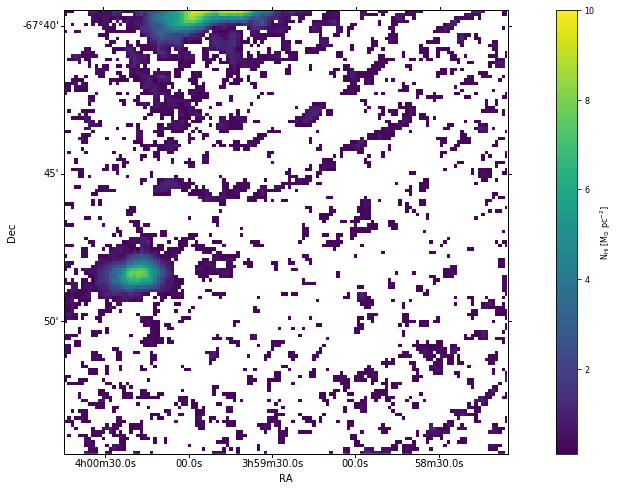

In [13]:
obj = objects[0]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 7.0
    improve_data(obs_collections[obj], obj, proj, cell, 0.5, 
                 'felocity,75,772,16,16')
cell_size, robust, line = visualise_current(proj, obj)

### NGC6215
This is fine and goes into the SHREG analysis.

This is object ngc6215
['/data/HI_Interferometry/C419/95-03-26/ngc6215.uvlin', '/data/HI_Interferometry/C419/95-08-12_1/ngc6215.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 14.0 arcsec.
The beam size is 46.8 by 43.6 arcsec
A third of the minor axis is 14.5
The weighting is 0.5
The line parameter is felocity,150,985,8,8


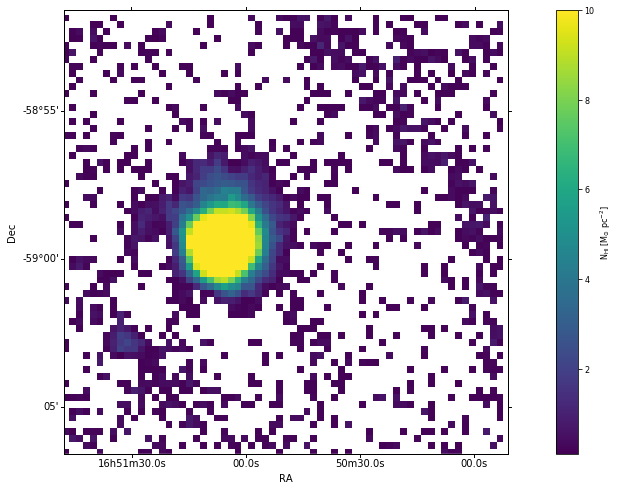

In [14]:
obj = objects[1]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 14.0
    improve_data(obs_collections[obj], obj, proj, cell, 0.5, 
                 'felocity,150,985,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### NGC1559
This is fine and goes into the SHREG analysis.

This is object ngc1559
['/data/HI_Interferometry/C419/95-03-25_2/ngc1559.uvlin', '/data/HI_Interferometry/C419/95-08-11_2/ngc1559.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 14.0 arcsec.
The beam size is 48.8 by 42.9 arcsec
A third of the minor axis is 14.3
The weighting is 0.5
The line parameter is felocity,150,772,8,8


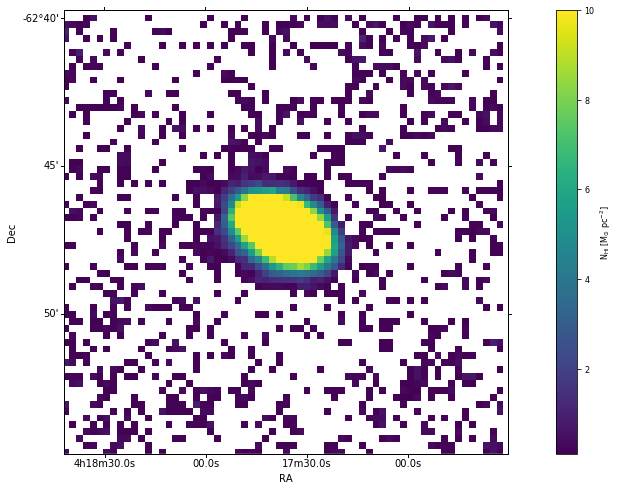

In [15]:
obj = objects[2]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 14.0
    improve_data(obs_collections[obj], obj, proj, cell, 0.5, 
                 'felocity,150,772,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### NGC6221
This is fine and goes into the SHREG analysis.

This is object ngc6221
['/data/HI_Interferometry/C419/95-08-12_1/ngc6221.uvlin', '/data/HI_Interferometry/C419/95-03-25_1/ngc6221.uvlin', '/data/HI_Interferometry/C419/95-08-11_1/ngc6221.uvlin', '/data/HI_Interferometry/C419/95-08-10_1/ngc6221.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 16.0 arcsec.
The beam size is 56.8 by 49.3 arcsec
A third of the minor axis is 16.4
The weighting is 0.5
The line parameter is felocity,150,985,8,8


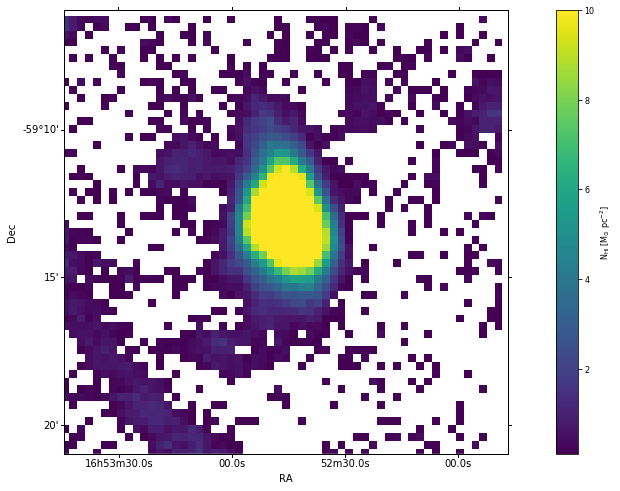

In [16]:
obj = objects[3]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 16.0
    improve_data(obs_collections[obj], obj, proj, cell, 0.5, 
                 'felocity,150,985,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### NGC6810
Too small for kinematic modelling.

This is object ngc6810
['/data/HI_Interferometry/C419/96-04-20_2/ngc6810.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 24.0 arcsec.
The beam size is 106.8 by 76.1 arcsec
A third of the minor axis is 25.4
The weighting is 0.5
The line parameter is felocity,150,1412,8,8


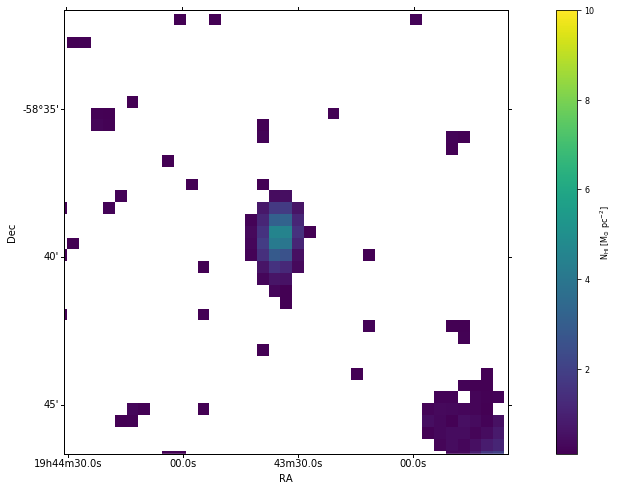

In [17]:
obj = objects[5]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 24.0
    improve_data(obs_collections[obj], obj, proj, cell, 0.5, 
                 'felocity,150,1412,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### NGC3263
Beam too elongated.

### NGC6872
Invert failed

### NGC3620
Too small for kinematic modelling.

This is object ngc3620
['/data/HI_Interferometry/C419/95-08-14_1/ngc3620.uvlin', '/data/HI_Interferometry/C419/95-03-28_1/ngc3620.uvlin', '/data/HI_Interferometry/C419/95-08-13/ngc3620.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 24.0 arcsec.
The beam size is 106.3 by 71.6 arcsec
A third of the minor axis is 23.9
The weighting is 2.0
The line parameter is felocity,75,1179,16,16


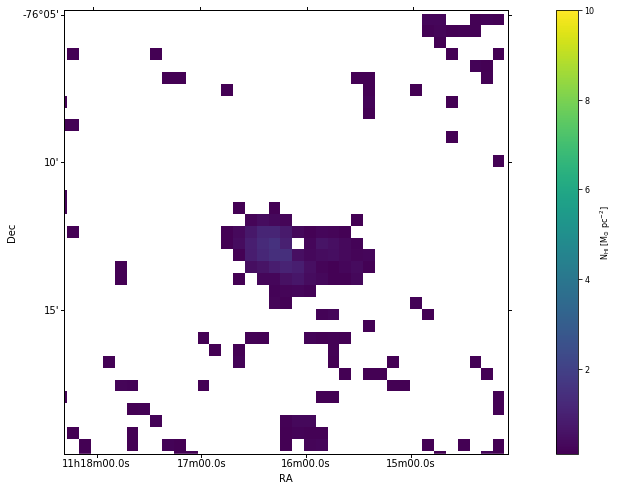

In [18]:
obj = objects[8]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 24.0
    improve_data(obs_collections[obj], obj, proj, cell, 2.0, 
                 'felocity,75,1179,16,16')
cell_size, robust, line = visualise_current(proj, obj)

### NGC7205
This is fine and I'll try to include this in the kinematic modelling. 

This is object ngc7205
['/data/HI_Interferometry/C419/96-04-21/ngc7205.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 30.0 arcsec.
The beam size is 98.0 by 86.5 arcsec
A third of the minor axis is 28.8
The weighting is 0.5
The line parameter is felocity,150,1199,8,8


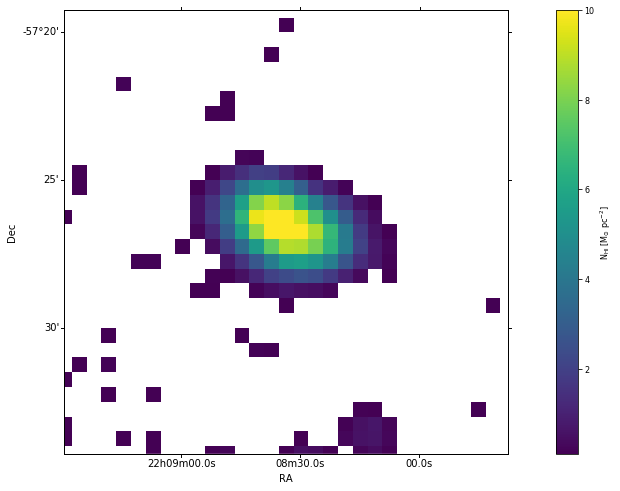

In [19]:
obj = objects[9]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 30.0
    improve_data(obs_collections[obj], obj, proj, 30.0, 0.5, 
                 'felocity,150,1199,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### NGC3882
This fine and I will try to include it in the kinematic modelling. 

This is object ngc3882
['/data/HI_Interferometry/C419/96-04-19_2/ngc3882.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 27.0 arcsec.
The beam size is 104.2 by 83.7 arcsec
A third of the minor axis is 27.9
The weighting is 0.5
The line parameter is felocity,150,1199,8,8


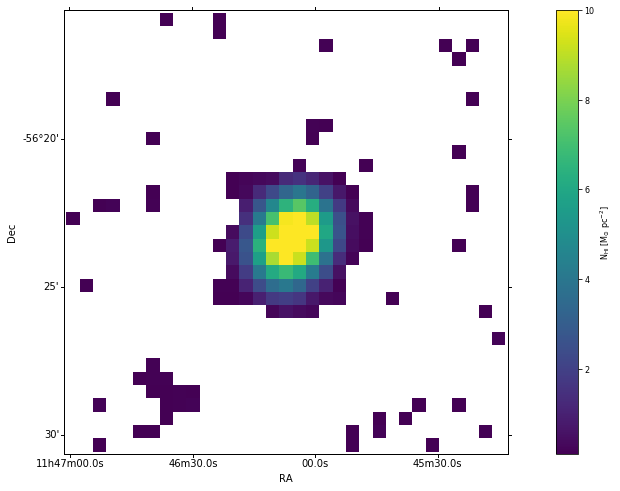

In [20]:
obj = objects[10]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 27.0
    improve_data(obs_collections[obj], obj, proj, cell, 0.5, 
                 'felocity,150,1199,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### NGC7552
This is fine and will be used in the SHREG analysis. 

This is object ngc7552
['/data/HI_Interferometry/C419/95-08-09/ngc7552.uvlin', '/data/HI_Interferometry/C419/95-03-27/ngc7552.uvlin', '/data/HI_Interferometry/C419/95-03-24_1/ngc7552.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 14.0 arcsec.
The beam size is 61.9 by 45.0 arcsec
A third of the minor axis is 15.0
The weighting is 0.5
The line parameter is felocity,150,985,8,8


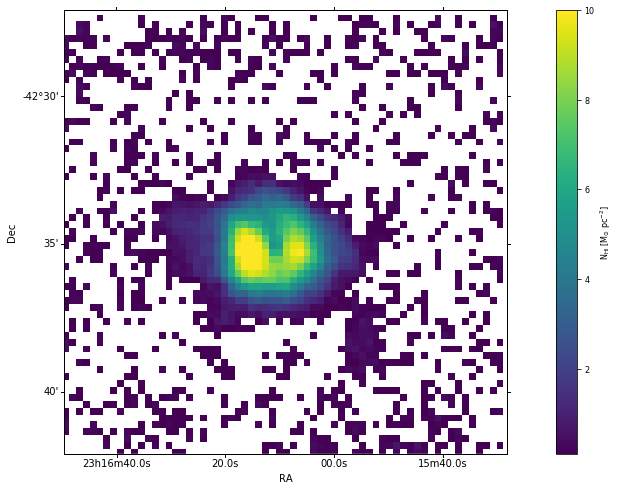

In [21]:
obj = objects[11]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 14.0
    improve_data(obs_collections[obj], obj, proj, cell, 0.5, 
                 'felocity,150,985,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### NGC7582
This is fine and will be used in the SHREG analysis.

This is object ngc7582
['/data/HI_Interferometry/C419/95-08-14_2/ngc7582.uvlin', '/data/HI_Interferometry/C419/95-03-29_1/ngc7582.uvlin', '/data/HI_Interferometry/C419/95-03-28_2/ngc7582.uvlin', '/data/HI_Interferometry/C419/95-08-10_2/ngc7582.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 19.0 arcsec.
The beam size is 84.2 by 60.8 arcsec
A third of the minor axis is 20.3
The weighting is 0.5
The line parameter is felocity,150,985,8,8


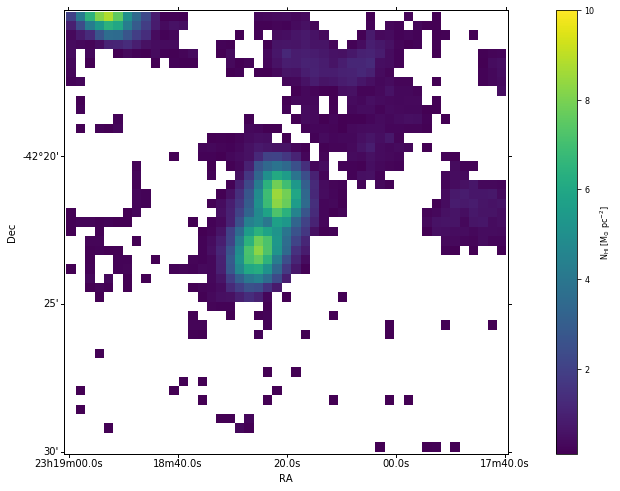

In [22]:
obj = objects[13]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 19.0
    improve_data(obs_collections[obj], obj, proj, cell, 0.5, 
                 'felocity,150,985,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### NGC1448

This is object ngc1448
['/data/HI_Interferometry/C419/96-04-20_3/ngc1448.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 30.0 arcsec.
The beam size is 237.1 by 95.9 arcsec
A third of the minor axis is 32.0
The weighting is 2.0
The line parameter is felocity,150,559,8,8


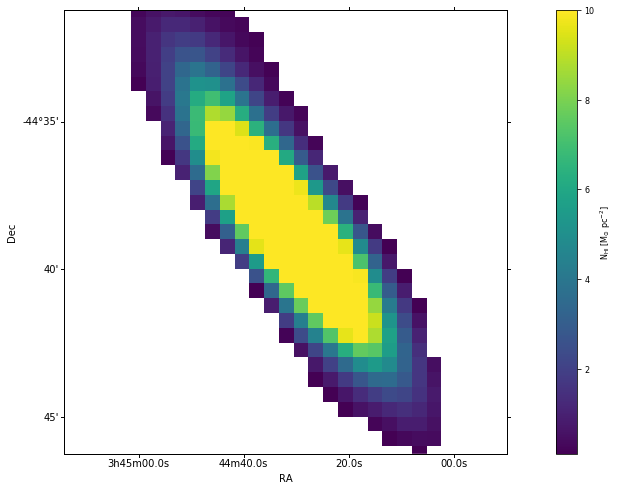

In [23]:
obj = objects[14]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 30.0
    improve_data(obs_collections[obj], obj, proj, cell, 2.0, 
                 'felocity,150,559,8,8', imsize=round(25.*60./cell))
cell_size, robust, line = visualise_current(proj, obj)

### NGC5643
This is fine and will be used in the SHREG kinematic analysis.

This is object ngc5643
['/data/HI_Interferometry/C419/95-03-29_2/ngc5643.uvlin', '/data/HI_Interferometry/C419/95-08-15/ngc5643.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 16.0 arcsec.
The beam size is 56.8 by 49.9 arcsec
A third of the minor axis is 16.6
The weighting is 0.5
The line parameter is felocity,150,559,8,8


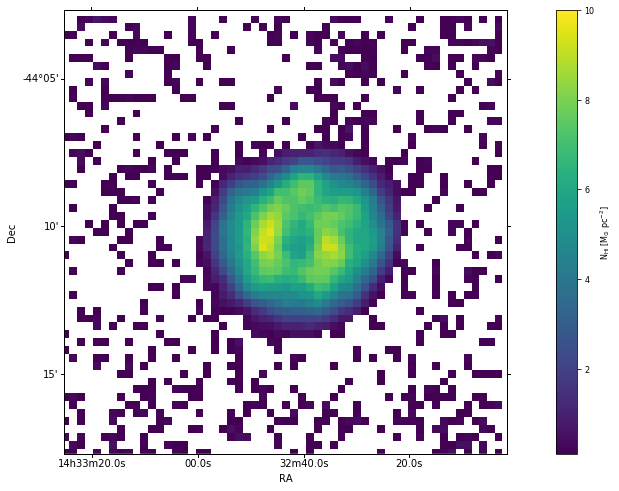

In [24]:
obj = objects[15]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 16.0
    improve_data(obs_collections[obj], obj, proj, cell, 0.5, 
                 'felocity,150,559,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### NGC986
Detection of ESO299-6 at edge of HPBW, NGC986 is only at the edge of the cube... 

## C530

In [25]:
objects = ['e140-31', 'eso118-g34', 'eso_137-45', 'eso_138-1', 'eso263', 
           'eso_269-80', 'eso_318-21', 'i4765', 'i4847', 'i4889', 'ic1459', 
           'n1947', 'n2328', 'n3125', 'n6799', 'n6850', 'n6920', 'ngc2434', 
           'ngc_2640', 'ngc3108', 'ngc5140', 'ngc7049', 'ngc7070a', 'ngc7097', 
           'ngc_802']
proj = projects[3]
print(len(objects))
obs_dates = {
            '1996-04-23': {'phase': '1315-46.1402',
                           'bandpass': '1934-638.1402',
                           'sci_sou':  ['ngc5140.1402']},
            '1996-04-25': {'phase': '1039-47.1407',
                           'bandpass': '1934-638.1407',
                           'sci_sou':  ['eso263.1407']},
            '1996-04-26': {'phase': '1039-47.1407',
                           'bandpass': '1934-638.1407',
                           'sci_sou':  ['ngc3108.1407']},
            '1996-09-19': {'phase': '0008-421.1412',
                           'bandpass': '1934-638.1412',
                           'sci_sou':  ['027-g21.1412', 'ic1459.1412']},
            '1996-09-20': {'phase': '0515-674.1416',
                           'bandpass': '1934-638.1416',
                           'sci_sou':  ['n1947.1416']},
            '1996-09-22_1': {'phase': '1934-638.1409',
                             'bandpass': '2134-470.1409',
                             'sci_sou':  ['ngc7070a.1409', 'ngc7097.1409']},
            '1996-11-10': {'phase': '2353-686.1409',
                           'bandpass': '1934-638.1409',
                           'sci_sou':  ['027-g21.1409']},
            '1996-11-11': {'phase': '0647-475.1415',
                           'bandpass': '1934-638.1415',
                           'sci_sou':  ['n2328.1415']},
            '1996-11-25': {'phase': '1039-47.1407',
                           'bandpass': '1934-638.1407',
                           'sci_sou':  ['ngc3108.1407']},
            '1996-11-29': {'phase': '0823-500.1416',
                           'bandpass': '1934-638.1416',
                           'sci_sou':  ['ngc_2640.1416']},
            '1996-12-01': {'phase': '0420-625.1415',
                           'bandpass': '1934-638.1415',
                           'sci_sou':  ['eso118-g34.1415']},
            '1997-03-31': {'phase': '0420-625.1415',
                           'bandpass': '1934-638.1415',
                           'sci_sou':  ['eso118-g34.1415']},
            '1997-09-23': {'phase': '0008-421.1412',
                           'bandpass': '1934-638.1412',
                           'sci_sou':  ['ic1459.1412']},
            '1997-09-24_1': {'phase': '0757-737.1414',
                             'bandpass': '0823-500.1414',
                             'sci_sou':  ['ngc2434.1414']},
            '1997-09-24_2': {'phase': '2134-470.1409',
                             'bandpass': '1934-638.1409',
                             'sci_sou':  ['ngc7049.1409', 'ngc7070a.1409']},
            '1999-09-08': {'phase': '0208-512.1413',
                           'bandpass': '1934-638.1413',
                           'sci_sou':  ['ngc_802.1413']},
            '1999-10-03': {'phase': '0647-475.1415',
                           'bandpass': '1934-638.1415',
                           'sci_sou':  ['n2328.1415']},
            '2001-07-01': {'phase': '1934-638.1405',
                           'bandpass': '1934-638.1405',
                           'sci_sou':  ['n6799.1405']},
            '2001-07-02': {'phase': '1934-638.1399',
                           'bandpass': '1934-638.1399',
                           'sci_sou':  ['i4765.1399', 'i4847.1399',
                                        'n6850.1399']},
            '2001-07-03': {'phase': '1934-638.1407',
                           'bandpass': '1934-638.1407',
                           'sci_sou':  ['e140-31.1407', 'i4889.1407']},
            '2001-07-04': {'phase': '1934-638.1406',
                           'bandpass': '1934-638.1406',
                           'sci_sou':  ['n6799.1406', 'n6920.1406']},
            '2002-03-07': {'phase': '1722-55.1405',
                           'bandpass': '1934-638.1405',
                           'sci_sou':  ['eso_137-45.1405']},
            '2002-03-09': {'phase': '1722-55.1408',
                           'bandpass': '1934-638.1408',
                           'sci_sou':  ['eso_138-1.1408']},
            '2002-03-11': {'phase': '1015-314.1415',
                           'bandpass': '1934-638.1415',
                           'sci_sou':  ['n3125.1415']},
            '2002-03-15_1': {'phase': '1421-490.1406',
                             'bandpass': '1934-638.1406',
                             'sci_sou':  ['eso_269-80.1406']},
            '2002-03-15_2': {'phase': '1018-426.1398',
                             'bandpass': '1934-638.1398',
                             'sci_sou':  ['eso_318-21.1398']}
                   }
obs_collections = sort_data(obs_dates)

25


### ESO140-31
Detected but only low signal to noise and spatial resolution probably not good enough for kinematic modelling. 

This is object e140-31
['/data/HI_Interferometry/C530/2001-07-03/e140-31.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 35.0 arcsec.
The beam size is 117.0 by 105.5 arcsec
A third of the minor axis is 35.2
The weighting is 2.0
The line parameter is felocity,75,2270,16,16


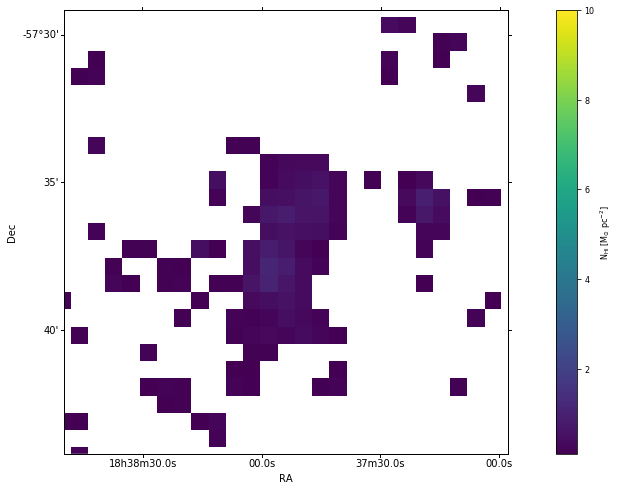

In [26]:
obj = objects[0]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 35.0
    improve_data(obs_collections[obj], obj, proj, cell, 2.0, 
                 'felocity,75,2270,16,16')
cell_size, robust, line = visualise_current(proj, obj)

### ESO118-34
Detected but resolution probaly not good enough for kinematic modelling.

This is object eso118-g34
['/data/HI_Interferometry/C530/1997-03-31/eso118-g34.uvlin', '/data/HI_Interferometry/C530/1996-12-01/eso118-g34.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 20.0 arcsec.
The beam size is 90.5 by 70.4 arcsec
A third of the minor axis is 23.5
The weighting is 1.0
The line parameter is felocity,75,559,16,16


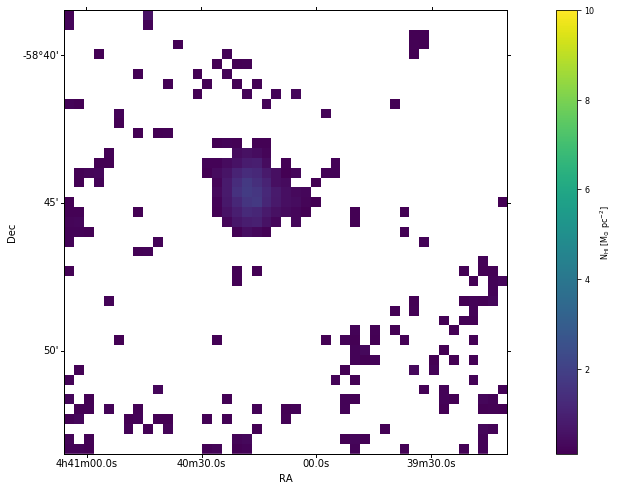

In [27]:
obj = objects[1]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 20.0
    improve_data(obs_collections[obj], obj, proj, cell, 1.0, 
                 'felocity,75,559,16,16')
cell_size, robust, line = visualise_current(proj, obj)

### ESO263-48
No detection of ESO263-48 but of ESO263-47, not useful for kinematic modelling. 

This is object eso263
['/data/HI_Interferometry/C530/1996-04-25/eso263.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 40.0 arcsec.
The beam size is 147.9 by 126.8 arcsec
A third of the minor axis is 42.3
The weighting is 2.0
The line parameter is felocity,150,2270,8,8


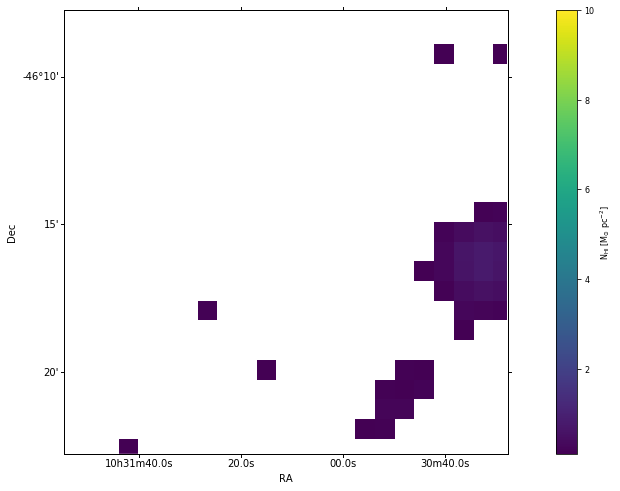

In [28]:
obj = objects[4]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 40.0
    improve_data(obs_collections[obj], obj, proj, cell, 2.0, 
                 'felocity,150,2270,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### ESO318-21
The data are fine but the galaxy is not detected.

This is object eso_318-21
['/data/HI_Interferometry/C530/2002-03-15_2/eso_318-21.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 28.0 arcsec.
The beam size is 269.6 by 87.2 arcsec
A third of the minor axis is 29.1
The weighting is 2.0
The line parameter is felocity,75,4218,16,16


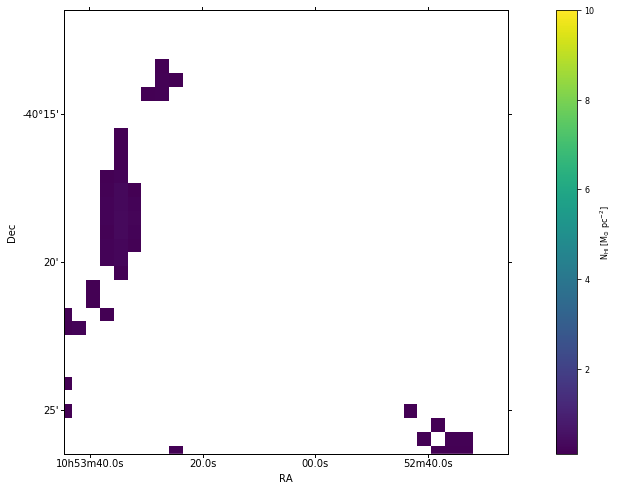

In [29]:
obj = objects[6]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 28.0
    improve_data(obs_collections[obj], obj, proj, cell, 2.0, 
                 'felocity,75,4218,16,16')
cell_size, robust, line = visualise_current(proj, obj)

### IC4847
The data are fine, but the galaxy is hardly detected and will not be used for the kinematic analysis. 

This is object i4847
['/data/HI_Interferometry/C530/2001-07-02/i4847.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 20.0 arcsec.
The beam size is 82.8 by 64.0 arcsec
A third of the minor axis is 21.3
The weighting is 2.0
The line parameter is felocity,150,4000,8,8


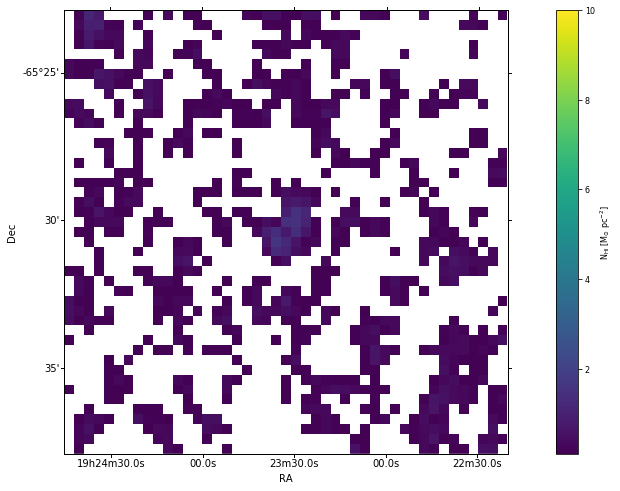

In [30]:
obj = objects[8]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 20.0
    improve_data(obs_collections[obj], obj, proj, cell, 2.0, 
                 'felocity,150,4000,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### IC4889
The data are fine but can probably not be used in the kinematic analysis. 

This is object i4889
['/data/HI_Interferometry/C530/2001-07-03/i4889.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 30.0 arcsec.
The beam size is 97.6 by 90.7 arcsec
A third of the minor axis is 30.2
The weighting is 0.5
The line parameter is felocity,75,2270,16,16


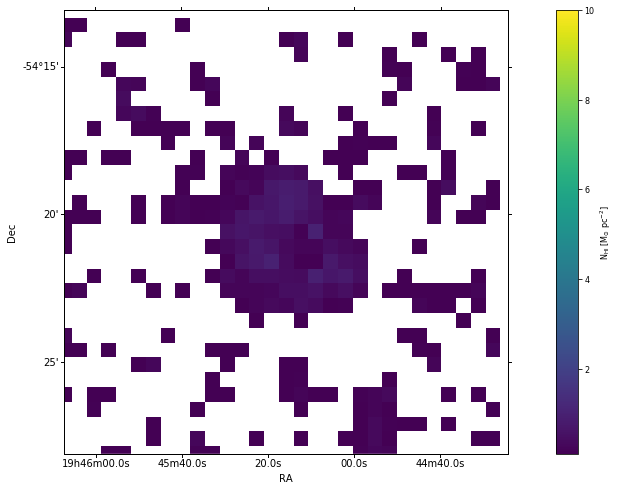

In [31]:
obj = objects[9]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 30.0
    improve_data(obs_collections[obj], obj, proj, cell, 0.5, 
                 'felocity,75,2270,16,16')
cell_size, robust, line = visualise_current(proj, obj)

### NGC1947
The data are fine, but they can not be used for the kinematic modelling. 

This is object n1947
['/data/HI_Interferometry/C530/1996-09-20/n1947.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 27.0 arcsec.
The beam size is 95.9 by 83.3 arcsec
A third of the minor axis is 27.8
The weighting is 0.5
The line parameter is felocity,75,347,16,16


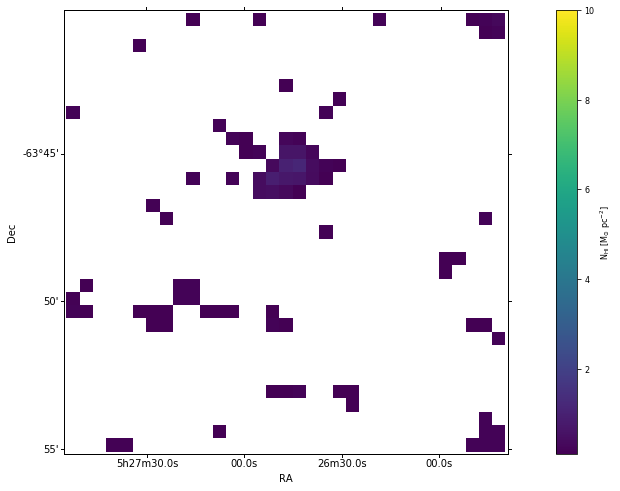

In [32]:
obj = objects[11]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 27.0
    improve_data(obs_collections[obj], obj, proj, cell, 0.5, 
                 'felocity,75,347,16,16')
cell_size, robust, line = visualise_current(proj, obj)

### NGC 2328
The data are fine and I can try to use them in the kinematic modelling. 

This is object n2328
['/data/HI_Interferometry/C530/1999-10-03/n2328.uvlin', '/data/HI_Interferometry/C530/1996-11-11/n2328.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 14.0 arcsec.
The beam size is 61.9 by 42.7 arcsec
A third of the minor axis is 14.2
The weighting is 2.0
The line parameter is felocity,150,559,8,8


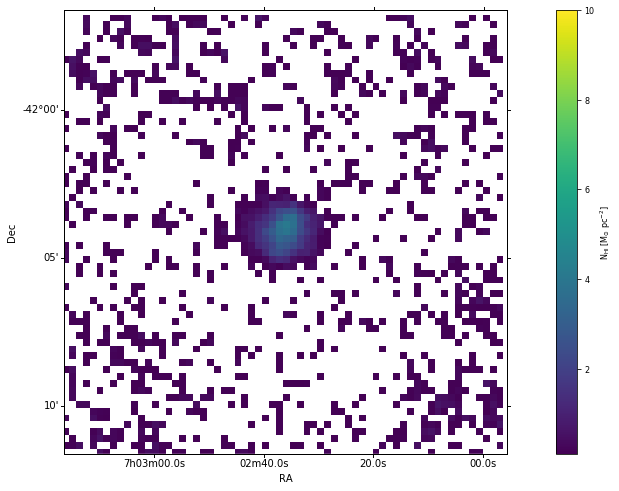

In [33]:
obj = objects[12]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 14.0
    improve_data(obs_collections[obj], obj, proj, cell, 2.0, 
                 'felocity,150,559,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### NGC3125
The data are fine and I will try to include them in the kinematic modelling.

This is object n3125
['/data/HI_Interferometry/C530/2002-03-11/n3125.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 30.0 arcsec.
The beam size is 169.9 by 88.2 arcsec
A third of the minor axis is 29.4
The weighting is 0.5
The line parameter is felocity,75,559,16,16


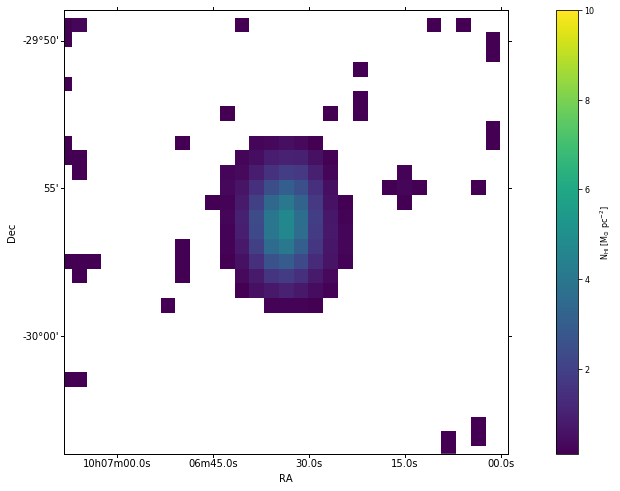

In [34]:
obj = objects[13]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 30.0
    improve_data(obs_collections[obj], obj, proj, cell, 0.5, 
                 'felocity,75,559,16,16')
cell_size, robust, line = visualise_current(proj, obj)

### NGC6799
The data are fine and will try to include them in the kinematic modelling.

This is object n6799
['/data/HI_Interferometry/C530/2001-07-01/n6799.uvlin', '/data/HI_Interferometry/C530/2001-07-04/n6799.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 26.0 arcsec.
The beam size is 91.2 by 81.0 arcsec
A third of the minor axis is 27.0
The weighting is 0.5
The line parameter is felocity,75,2485,16,16


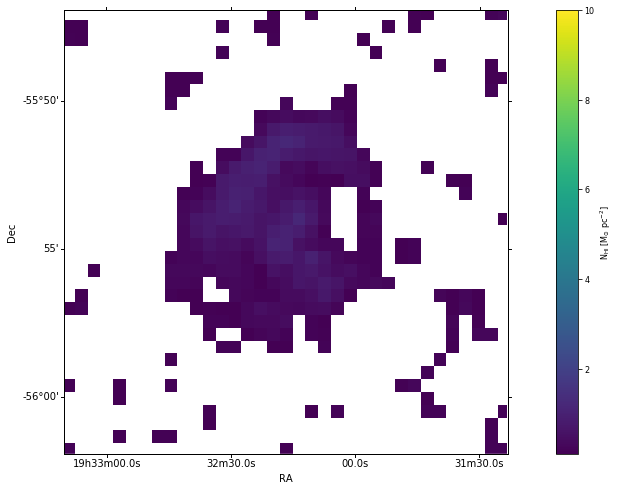

In [35]:
obj = objects[14]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 26.0
    improve_data(obs_collections[obj], obj, proj, cell, 0.5, 
                 'felocity,75,2485,16,16')
cell_size, robust, line = visualise_current(proj, obj)

### NGC6850
The data are fine, no detection of NGC6850 but detection of IC4933, spatial resolution is soso, but I can try the kinematic modelling. 

This is object n6850
['/data/HI_Interferometry/C530/2001-07-02/n6850.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 20.0 arcsec.
The beam size is 87.2 by 61.5 arcsec
A third of the minor axis is 20.5
The weighting is 2.0
The line parameter is felocity,150,4000,8,8


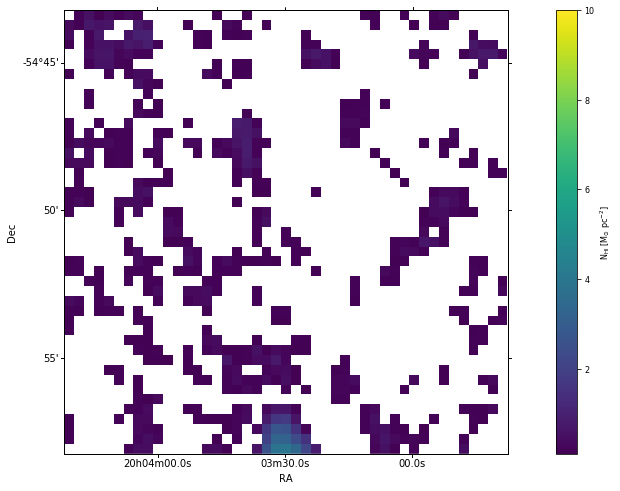

In [36]:
obj = objects[15]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 20.0
    improve_data(obs_collections[obj], obj, proj, cell, 2.0, 
                 'felocity,150,4000,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### NGC6920
The data are fine, I don't exactly detect NGC6920 but a common envelope of ESO26-5 and NGC6920, which is centred on ESO26-5. There is a velocity gradient in this HI complex, so I'll try to model it. 

This is object n6920
['/data/HI_Interferometry/C530/2001-07-04/n6920.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 36.0 arcsec.
The beam size is 125.4 by 108.5 arcsec
A third of the minor axis is 36.2
The weighting is 2.0
The line parameter is felocity,150,2485,8,8


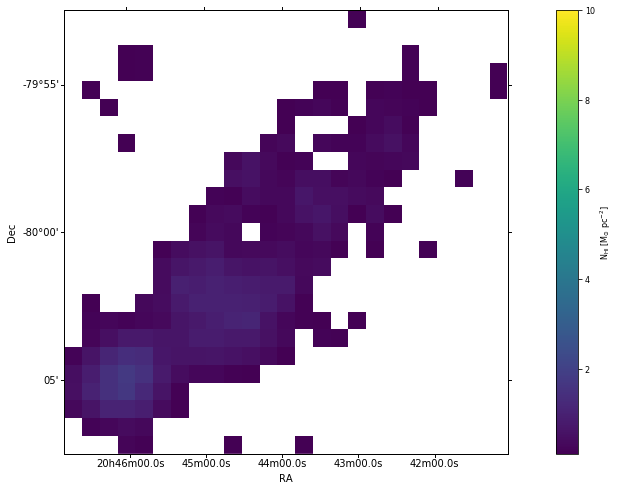

In [37]:
obj = objects[16]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 36.0
    improve_data(obs_collections[obj], obj, proj, cell, 2.0, 
                 'felocity,150,2485,8,8', imsize=round(20. * 60. / cell))
cell_size, robust, line = visualise_current(proj, obj)

### NGC2434
Not detected.

This is object ngc_2640
['/data/HI_Interferometry/C530/1996-11-29/ngc_2640.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 37.0 arcsec.
The beam size is 132.1 by 113.9 arcsec
A third of the minor axis is 38.0
The weighting is 2.0
The line parameter is felocity,75,347,16,16


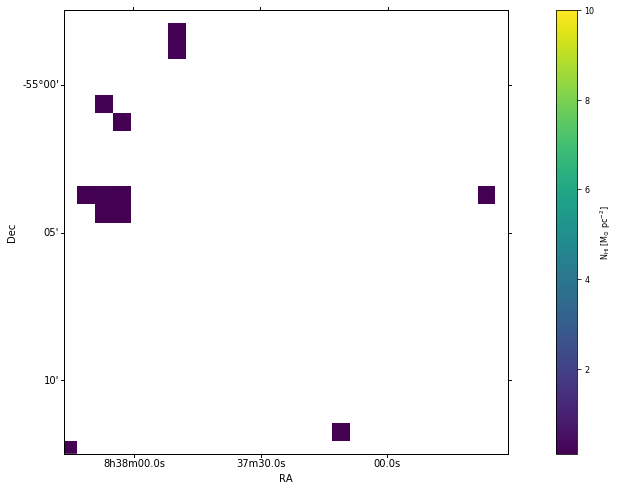

In [38]:
obj = objects[18]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 37.0
    improve_data(obs_collections[obj], obj, proj, cell, 2.0, 
                 'felocity,75,347,16,16')
cell_size, robust, line = visualise_current(proj, obj)

### NGC3108
The data are fine and I will try to use them in the kinematic analysis. 

This is object ngc3108
['/data/HI_Interferometry/C530/1996-11-25/ngc3108.uvlin', '/data/HI_Interferometry/C530/1996-04-26/ngc3108.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 19.0 arcsec.
The beam size is 118.6 by 57.3 arcsec
A third of the minor axis is 19.1
The weighting is 0.5
The line parameter is felocity,150,2270,8,8


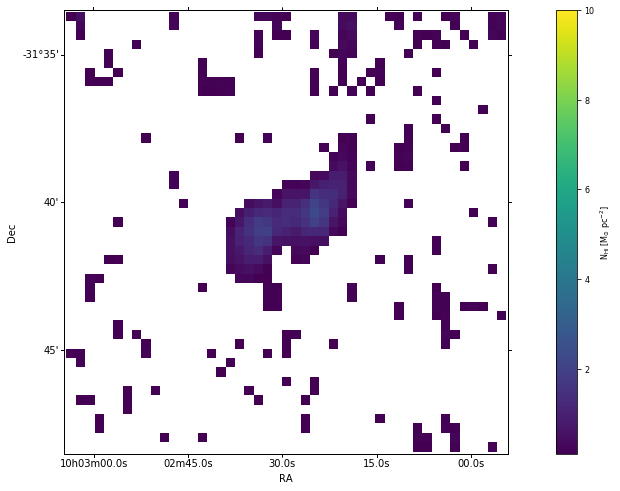

In [39]:
obj = objects[19]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 19.0
    improve_data(obs_collections[obj], obj, proj, cell, 0.5, 
                 'felocity,150,2270,8,8')
cell_size, robust, line = visualise_current(proj, obj)

## C557

In [40]:
objects = ['eso235-58', 'eso415-g26', 'eso_474-g26', 'am2020-504']
proj = projects[4]
print(proj)
print(len(objects))
obs_dates = {
            '96-10-01_1': {'phase': '2004-447.1397',
                           'bandpass': '1934-638.1397',
                           'sci_sou':  ['am2020-504.1397']},
            '96-10-01_2': {'phase': '0153-410.1399',
                           'bandpass': '1934-638.1399',
                           'sci_sou':  ['eso415-g26.1399']},
            '96-10-06': {'phase': '2106-413.1400',
                         'bandpass': '1934-638.1400',
                         'sci_sou':  ['eso235-58.1400']},
            '96-10-07': {'phase': '0008-421.1347',
                         'bandpass': '1934-638.1347',
                         'sci_sou':  ['eso_474-g26.1347']},
            '96-10-22': {'phase': '2106-413.1400',
                         'bandpass': '1934-638.1400',
                         'sci_sou':  ['eso235-58.1400']},
            '96-10-23': {'phase': '0008-421.1347',
                         'bandpass': '1934-638.1347',
                         'sci_sou':  ['eso_474-g26.1347']},
            '96-11-12': {'phase': '2106-413.1400',
                         'bandpass': '1934-638.1400',
                         'sci_sou':  ['eso235-58.1400']},
            '96-11-13': {'phase': '0153-410.1399',
                         'bandpass': '1934-638.1399',
                         'sci_sou':  ['eso415-g26.1399']}
                   }
obs_collections = sort_data(obs_dates)

C557
4


### ESO235-58

This is object eso235-58
['/data/HI_Interferometry/C557/96-10-06/eso235-58.uvlin', '/data/HI_Interferometry/C557/96-11-12/eso235-58.uvlin', '/data/HI_Interferometry/C557/96-10-22/eso235-58.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 11.0 arcsec.
The beam size is 48.6 by 33.8 arcsec
A third of the minor axis is 11.3
The weighting is 2.0
The line parameter is felocity,150,3783,8,8


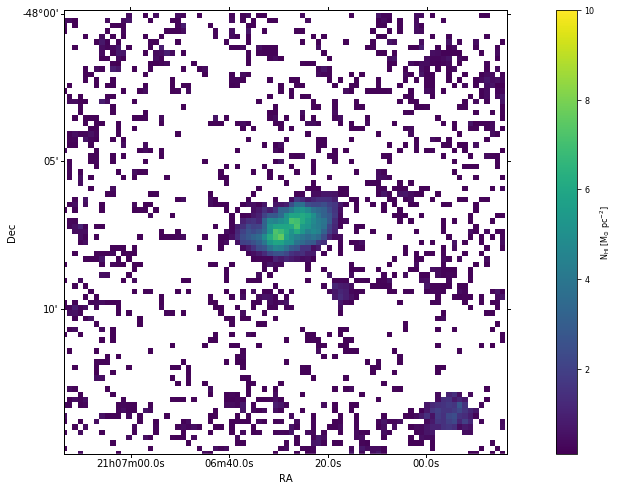

In [41]:
obj = objects[0]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 11.0
    improve_data(obs_collections[obj], obj, proj, cell, 2.0, 
                 'felocity,150,3783,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### ESO415-26
The data are fine but can not be used for the kinematic analysis. 

This is object eso415-g26
['/data/HI_Interferometry/C557/96-10-01_2/eso415-g26.uvlin', '/data/HI_Interferometry/C557/96-11-13/eso415-g26.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 18.0 arcsec.
The beam size is 91.5 by 51.8 arcsec
A third of the minor axis is 17.3
The weighting is 0.5
The line parameter is felocity,75,4000,16,16


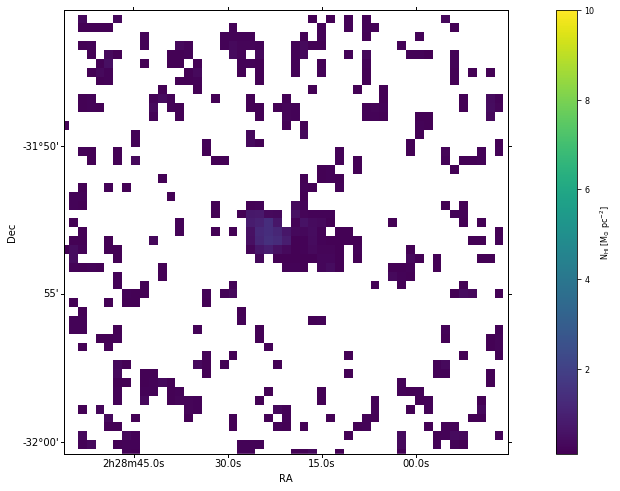

In [42]:
obj = objects[1]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 18.0
    improve_data(obs_collections[obj], obj, proj, cell, 0.5, 
                 'felocity,75,4000,16,16')
cell_size, robust, line = visualise_current(proj, obj)

### AM2020-504
The data are fine but can't be used for the kinematic modelling. 

This is object am2020-504
['/data/HI_Interferometry/C557/96-10-01_1/am2020-504.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 27.0 arcsec.
The beam size is 117.5 by 81.0 arcsec
A third of the minor axis is 27.0
The weighting is 0.5
The line parameter is felocity,75,4436,16,16


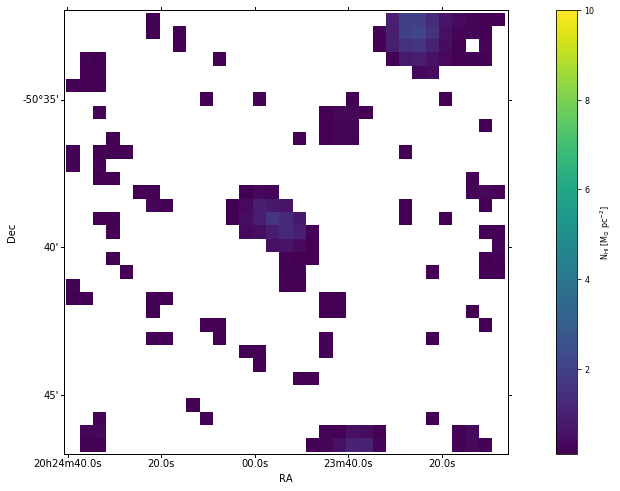

In [43]:
obj = objects[3]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 27.0
    improve_data(obs_collections[obj], obj, proj, cell, 0.5, 
                 'felocity,75,4436,16,16')
cell_size, robust, line = visualise_current(proj, obj)

## C600

In [44]:
objects = ['e325g11', 'e358g63', 'eso54-g24', 'n3137']
proj = projects[5]
print(proj)
print(len(objects))
obs_dates = {
            '97-01-04_1': {'phase': '1039-47.1415',
                           'bandpass': '1934-638.1415',
                           'sci_sou':  ['n3137.1415']},
            '97-01-04_2': {'phase': '1320-446.1418',
                           'bandpass': '1934-638.1418',
                           'sci_sou':  ['e325g11.1418']},
            '97-01-06_1': {'phase': '1039-47.1415',
                           'bandpass': '1934-638.1415',
                           'sci_sou':  ['n3137.1415']},
            '97-01-06_2': {'phase': '0400-319.1411',
                           'bandpass': '1934-638.1411',
                           'sci_sou':  ['e358g63.1411']},
            '97-03-12': {'phase': '0420-625.1353',
                         'bandpass': '1934-638.1353',
                         'sci_sou':  ['eso54-g24.1353']}
                   }
obs_collections = sort_data(obs_dates)

C600
4


### ESO358-63
The data are fine and will be used for the kinematic analysis.

This is object e358g63
['/data/HI_Interferometry/C600/97-01-06_2/e358g63.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 14.0 arcsec.
The beam size is 150.0 by 43.1 arcsec
A third of the minor axis is 14.4
The weighting is 2.0
The line parameter is felocity,150,1412,8,8


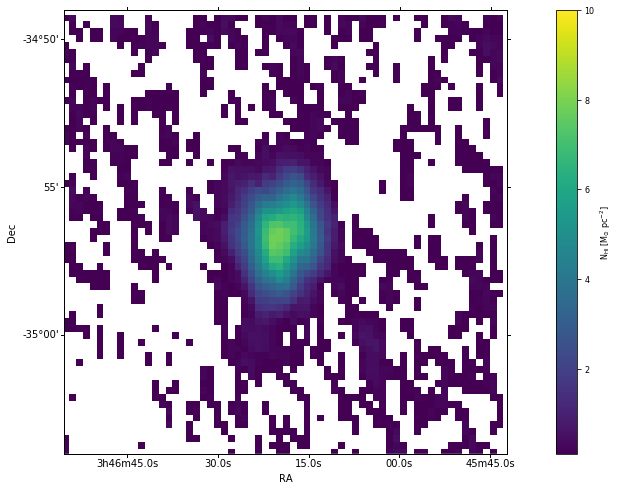

In [45]:
obj = objects[1]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 14.0
    improve_data(obs_collections[obj], obj, proj, cell, 2.0, 
                 'felocity,150,1412,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### C657

In [46]:
objects = ['eso54-g24']
proj = projects[6]
print(proj)
print(len(objects))
obs_dates = {
            '97-08-23': {'phase': '0420-625.1353',
                         'bandpass': '1934-638.1353',
                         'sci_sou':  ['eso54-g24.1353']},
            '97-09-06': {'phase': '0606-795.1353',
                         'bandpass': '1934-638.1353',
                         'sci_sou':  ['eso54-g24.1353']},
            '97-10-24': {'phase': '0606-795.1353',
                         'bandpass': '1934-638.1353',
                         'sci_sou':  ['eso54-g24.1353']}
                   }
obs_collections = sort_data(obs_dates)
# There are more data from project C600 but something is not OK with them. 
# obs_collections['eso54-g24'].append('C600_97-03-12')
print(obs_collections)

C657
1
{'eso54-g24': ['97-10-24', '97-08-23', '97-09-06']}


### ESO54-24
The data are fine and the galaxy is detected but  it is too small for the kinematic analysis. 

This is object eso54-g24
['/data/HI_Interferometry/C657/97-10-24/eso54-g24.uvlin', '/data/HI_Interferometry/C657/97-08-23/eso54-g24.uvlin', '/data/HI_Interferometry/C657/97-09-06/eso54-g24.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 12.0 arcsec.
The beam size is 54.8 by 39.8 arcsec
A third of the minor axis is 13.3
The weighting is 2.0
The line parameter is felocity,75,14345,16,16


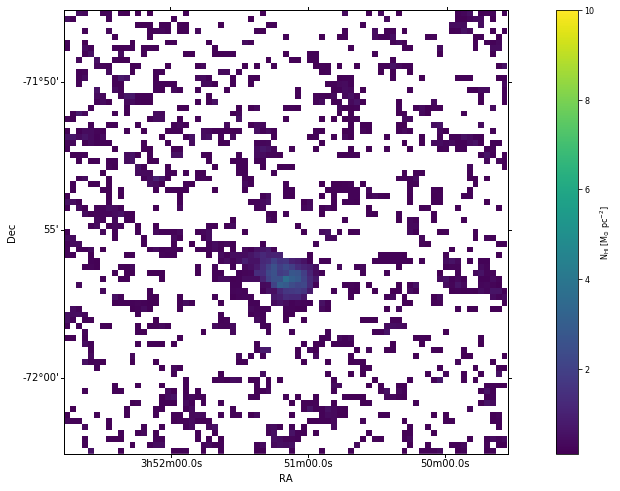

In [47]:
obj = objects[0]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 12.0
    improve_data(obs_collections[obj], obj, proj, cell, 2.0, 
                 'felocity,75,14345,16,16')
cell_size, robust, line = visualise_current(proj, obj)

## C732

In [48]:
objects = ['eso1450250', 'eso1870510', 'eso2490360', 'eso0280140', 
           'eso0350090', 'eso1040220', 'eso1040440']
proj = projects[7]
print(proj)
print(len(objects))
obs_dates = {
            '1998-05-31': {'phase': '1934-638.1417',
                           'bandpass': '1934-638.1417',
                           'sci_sou':  ['eso1040220.1417']},
            '1998-06-01_1': {'phase': '0407-658.1416',
                             'bandpass': '1934-638.1416',
                             'sci_sou':  ['eso0350090.1416']},
            '1998-06-01_2': {'phase': '1934-638.1417',
                             'bandpass': '1934-638.1417',
                             'sci_sou':  ['eso1040440.1417']},
            '1998-06-02': {'phase': '0252-712.1412',
                           'bandpass': '1934-638.1412',
                           'sci_sou':  ['eso0280140.1412']},
            '1998-06-06': {'phase': '0407-658.1417',
                           'bandpass': '1934-638.1417',
                           'sci_sou':  ['eso1040440.1417', 'eso2490360.1417']},
            '1998-06-24': {'phase': '1934-638.1412',
                           'bandpass': '1934-638.1412',
                           'sci_sou':  ['eso1450250.1412']},
            '1998-06-27': {'phase': '1934-638.1415',
                           'bandpass': '1934-638.1415',
                           'sci_sou':  ['eso1870510.1415']},
            '1998-06-28': {'phase': '1934-638.1417',
                           'bandpass': '1934-638.1417',
                           'sci_sou':  ['eso1040440.1417']},
            '1999-03-26': {'phase': '1934-638.1417',
                           'bandpass': '1934-638.1417',
                           'sci_sou':  ['eso1040440.1417']},
            '1999-03-27_1': {'phase': '1934-638.1417',
                             'bandpass': '1934-638.1417',
                             'sci_sou':  ['eso1040220.1417']},
            '1999-03-27_2': {'phase': '0008-421.1412',
                             'bandpass': '1934-638.1412',
                             'sci_sou':  ['eso1450250.1412']},
            '1999-03-27_3': {'phase': '1934-638.1412',
                             'bandpass': '1934-638.1412',
                             'sci_sou':  ['eso1450250.1412']},
            '1999-03-28_1': {'phase': '1934-638.1417',
                             'bandpass': '1934-638.1417',
                             'sci_sou':  ['eso1040440.1417']},
            '1999-03-28_2': {'phase': '1934-638.1412',
                             'bandpass': '1934-638.1412',
                             'sci_sou':  ['eso1450250.1412']},
            '1999-03-28_3': {'phase': '0407-658.1417',
                             'bandpass': '1934-638.1417',
                             'sci_sou':  ['eso2490360.1417']},
            '1999-03-29_1': {'phase': '0252-712.1412',
                             'bandpass': '1934-638.1412',
                             'sci_sou':  ['eso0280140.1412']},
            '1999-03-29_2': {'phase': '1934-638.1415',
                             'bandpass': '1934-638.1415',
                             'sci_sou':  ['eso1870510.1415']},
            '1999-03-30_0': {'phase': '1934-638.1415',
                             'bandpass': '1934-638.1415',
                             'sci_sou':  ['eso1870510.1415']},
            '1999-03-30_1': {'phase': '1934-638.1416',
                             'bandpass': '1934-638.1416',
                             'sci_sou':  ['eso0350090.1416']},
            '1999-03-30_2': {'phase': '0407-658.1416',
                             'bandpass': '1934-638.1416',
                             'sci_sou':  ['eso0350090.1416']},
            '1999-03-30_3': {'phase': '0407-658.1417',
                             'bandpass': '1934-638.1417',
                             'sci_sou':  ['eso2490360.1417']},
            '1999-04-11': {'phase': '1934-638.1412',
                           'bandpass': '1934-638.1412',
                           'sci_sou':  ['eso1450250.1412']},
            '1999-04-12_1': {'phase': '0252-712.1412',
                             'bandpass': '1934-638.1412',
                             'sci_sou':  ['eso0280140.1412']},
            '1999-04-12_2': {'phase': '1934-638.1415',
                             'bandpass': '1934-638.1415',
                             'sci_sou':  ['eso1870510.1415']},
            '1999-04-12_3': {'phase': '0407-658.1417',
                             'bandpass': '1934-638.1417',
                             'sci_sou':  ['eso2490360.1417']},
            '1999-04-13_1': {'phase': '1934-638.1417',
                             'bandpass': '1934-638.1417',
                             'sci_sou':  ['eso1040220.1417']},
            '1999-04-13_2': {'phase': '0252-712.1412',
                             'bandpass': '1934-638.1412',
                             'sci_sou':  ['eso0280140.1412']},
            '1999-04-28': {'phase': '1934-638.1417',
                           'bandpass': '1934-638.1417',
                           'sci_sou':  ['eso1040440.1417']}
                   }
obs_collections = sort_data(obs_dates)

C732
7


### ESO145-25
The data are fine and will be used for the SHREG kinematic analysis.

This is object eso1450250
['/data/HI_Interferometry/C732/1999-04-11/eso1450250.uvlin', '/data/HI_Interferometry/C732/1999-03-28_2/eso1450250.uvlin', '/data/HI_Interferometry/C732/1999-03-27_3/eso1450250.uvlin', '/data/HI_Interferometry/C732/1999-03-27_2/eso1450250.uvlin', '/data/HI_Interferometry/C732/1998-06-24/eso1450250.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 11.0 arcsec.
The beam size is 45.0 by 35.5 arcsec
A third of the minor axis is 11.8
The weighting is 2.0
The line parameter is felocity,150,1199,8,8


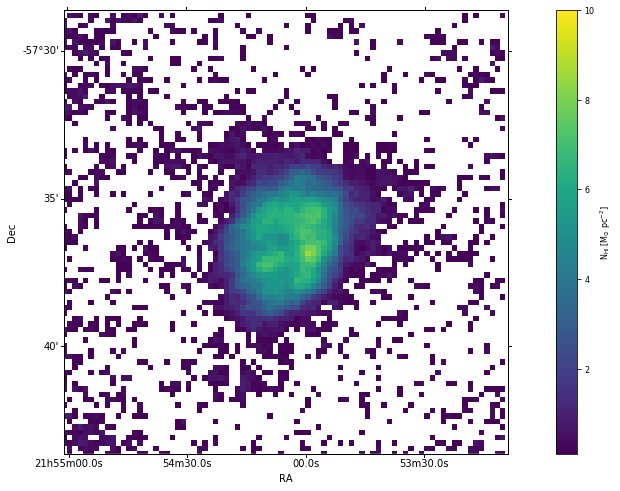

In [49]:
obj = objects[0]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 11.0
    improve_data(obs_collections[obj], obj, proj, cell, 2.0, 
                 'felocity,150,1199,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### ESO187-51
The data are fine and will go into the SHREG kinematic analysis.

This is object eso1870510
['/data/HI_Interferometry/C732/1999-04-12_2/eso1870510.uvlin', '/data/HI_Interferometry/C732/1999-03-29_2/eso1870510.uvlin', '/data/HI_Interferometry/C732/1999-03-30_0/eso1870510.uvlin', '/data/HI_Interferometry/C732/1998-06-27/eso1870510.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 9.0 arcsec.
The beam size is 36.3 by 27.1 arcsec
A third of the minor axis is 9.0
The weighting is 0.5
The line parameter is felocity,150,559,8,8


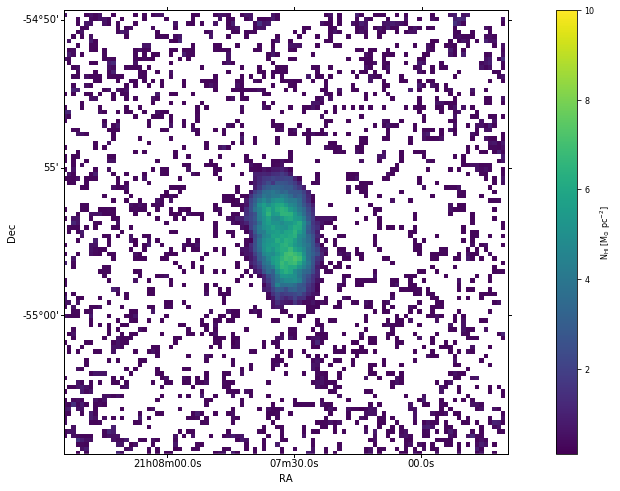

In [50]:
obj = objects[1]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 9.0
    improve_data(obs_collections[obj], obj, proj, cell, 0.5, 
                 'felocity,150,559,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### ESO249-36
The data are fine and will go into the kinematic analysis. 

This is object eso2490360
['/data/HI_Interferometry/C732/1999-04-12_3/eso2490360.uvlin', '/data/HI_Interferometry/C732/1999-03-28_3/eso2490360.uvlin', '/data/HI_Interferometry/C732/1999-03-30_3/eso2490360.uvlin', '/data/HI_Interferometry/C732/1998-06-06/eso2490360.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 10.0 arcsec.
The beam size is 44.0 by 32.5 arcsec
A third of the minor axis is 10.8
The weighting is 0.5
The line parameter is felocity,150,135,8,8


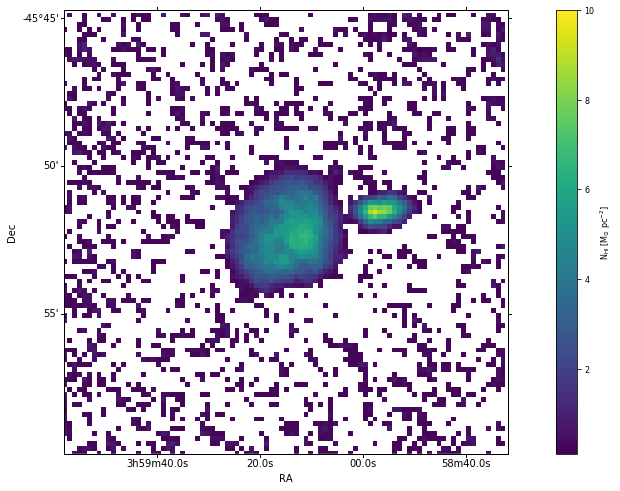

In [51]:
obj = objects[2]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 10.0
    improve_data(obs_collections[obj], obj, proj, cell, 0.5, 
                 'felocity,150,135,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### ESO28-14
The data are fine and will be used for the kinematic analysis. 

This is object eso0280140
['/data/HI_Interferometry/C732/1999-04-12_1/eso0280140.uvlin', '/data/HI_Interferometry/C732/1999-03-29_1/eso0280140.uvlin', '/data/HI_Interferometry/C732/1999-04-13_2/eso0280140.uvlin', '/data/HI_Interferometry/C732/1998-06-02/eso0280140.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 10.0 arcsec.
The beam size is 34.1 by 30.0 arcsec
A third of the minor axis is 10.0
The weighting is 0.5
The line parameter is felocity,150,1199,8,8


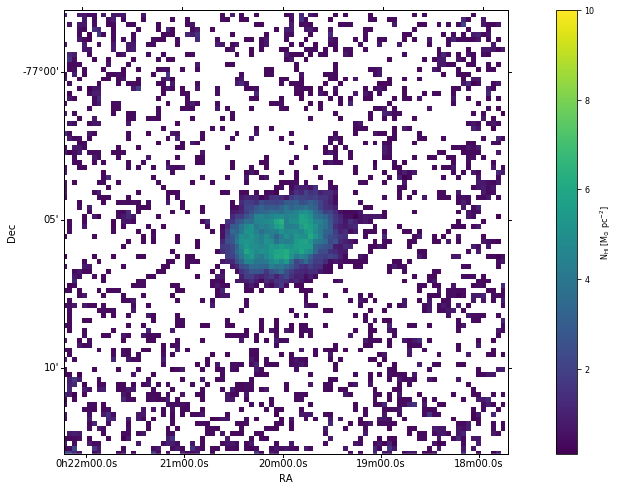

In [52]:
obj = objects[3]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 10.0
    improve_data(obs_collections[obj], obj, proj, cell, 0.5, 
                 'felocity,150,1199,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### ESO035-09
The data are fine but the galaxy is a bit too small for the kinematic analysis. 

This is object eso0350090
['/data/HI_Interferometry/C732/1998-06-01_1/eso0350090.uvlin', '/data/HI_Interferometry/C732/1999-03-30_1/eso0350090.uvlin', '/data/HI_Interferometry/C732/1999-03-30_2/eso0350090.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 10.0 arcsec.
The beam size is 39.9 by 33.9 arcsec
A third of the minor axis is 11.3
The weighting is 0.5
The line parameter is felocity,150,347,8,8


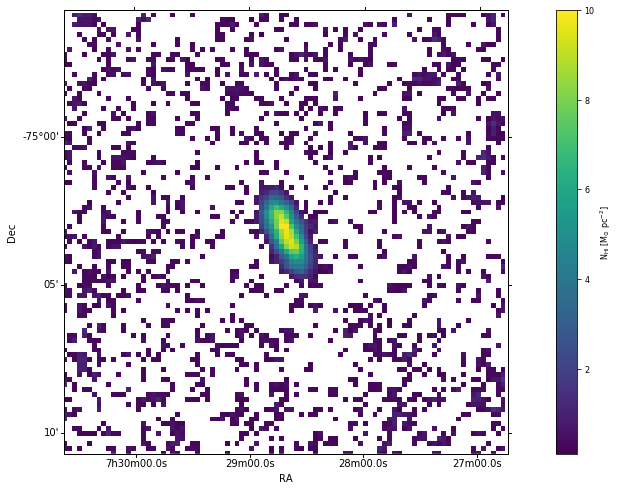

In [53]:
obj = objects[4]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 10.0
    improve_data(obs_collections[obj], obj, proj, cell, 0.5, 
                 'felocity,150,347,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### ESO104-22
The data are fine and will be used for the kinematic analysis. 

This is object eso1040220
['/data/HI_Interferometry/C732/1998-05-31/eso1040220.uvlin', '/data/HI_Interferometry/C732/1999-03-27_1/eso1040220.uvlin', '/data/HI_Interferometry/C732/1999-04-13_1/eso1040220.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 10.0 arcsec.
The beam size is 34.3 by 29.6 arcsec
A third of the minor axis is 9.9
The weighting is 0.5
The line parameter is felocity,150,135,8,8


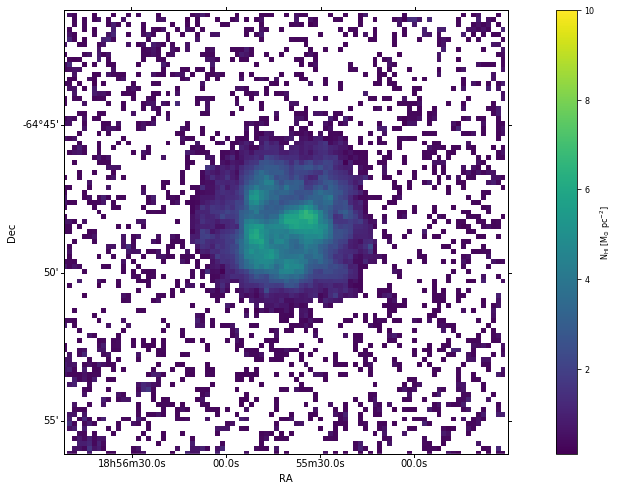

In [54]:
obj = objects[5]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 10.0
    improve_data(obs_collections[obj], obj, proj, cell, 0.5, 
                 'felocity,150,135,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### ESO104-44
The data are fine and I will at least try to include the galaxy into the kinematic analysis. 

This is object eso1040440
['/data/HI_Interferometry/C732/1998-06-01_2/eso1040440.uvlin', '/data/HI_Interferometry/C732/1999-03-26/eso1040440.uvlin', '/data/HI_Interferometry/C732/1999-03-28_1/eso1040440.uvlin', '/data/HI_Interferometry/C732/1998-06-06/eso1040440.uvlin', '/data/HI_Interferometry/C732/1998-06-28/eso1040440.uvlin', '/data/HI_Interferometry/C732/1999-04-28/eso1040440.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 10.0 arcsec.
The beam size is 33.5 by 29.8 arcsec
A third of the minor axis is 9.9
The weighting is 0.5
The line parameter is felocity,150,135,8,8


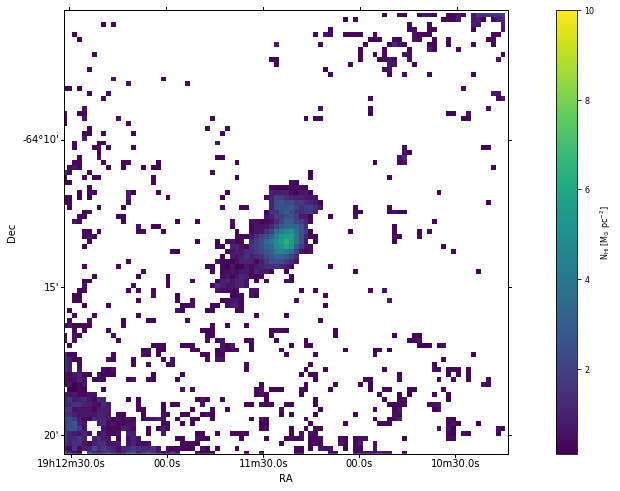

In [55]:
obj = objects[6]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 10.0
    improve_data(obs_collections[obj], obj, proj, cell, 0.5, 
                 'felocity,150,135,8,8')
cell_size, robust, line = visualise_current(proj, obj)

## C801

In [56]:
objects = ['eso383-05', 'ic4745', 'ngc6848', 'ic4757']
proj = projects[8]
print(proj)
print(len(objects))
obs_dates = {
            '2000-05-20': {'phase': '1320-446.1403',
                           'bandpass': '1934-638.1403',
                           'sci_sou':  ['eso383-05.1403']},
            '2000-05-21': {'phase': '1814-637.1398',
                           'bandpass': '1934-638.1398',
                           'sci_sou':  ['ic4745.1398']},
            '2000-05-23': {'phase': '1814-637.1404',
                           'bandpass': '1934-638.1404',
                           'sci_sou':  ['ic4757.1404']},
            '2000-05-24': {'phase': '1950-613.1400',
                           'bandpass': '1934-638.1400',
                           'sci_sou':  ['ngc6848.1400']}
                   }
obs_collections = sort_data(obs_dates)

C801
4


### ESO383-05
The data are fine and will go into the kinematic analysis.

This is object eso383-05
['/data/HI_Interferometry/C801/2000-05-20/eso383-05.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 8.0 arcsec.
The beam size is 51.3 by 25.6 arcsec
A third of the minor axis is 8.5
The weighting is 2.0
The line parameter is felocity,150,3133,8,8


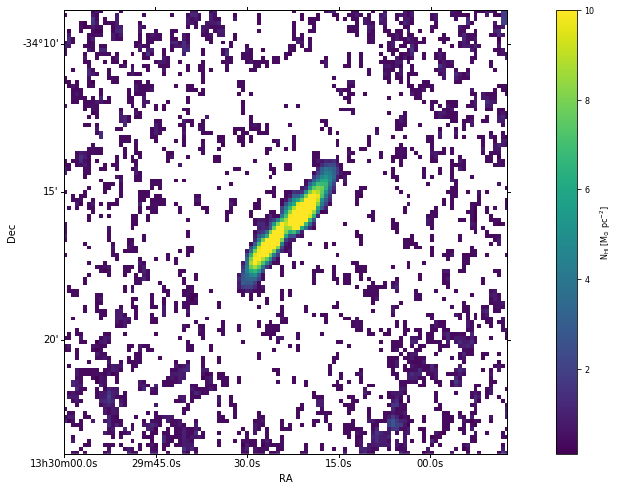

In [57]:
obj = objects[0]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 8.0
    improve_data(obs_collections[obj], obj, proj, cell, 2.0, 
                 'felocity,150,3133,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### IC4745
The data are fine and will go into the kinematic analysis. 

This is object ic4745
['/data/HI_Interferometry/C801/2000-05-21/ic4745.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 8.0 arcsec.
The beam size is 31.9 by 26.1 arcsec
A third of the minor axis is 8.7
The weighting is 2.0
The line parameter is felocity,150,4218,8,8


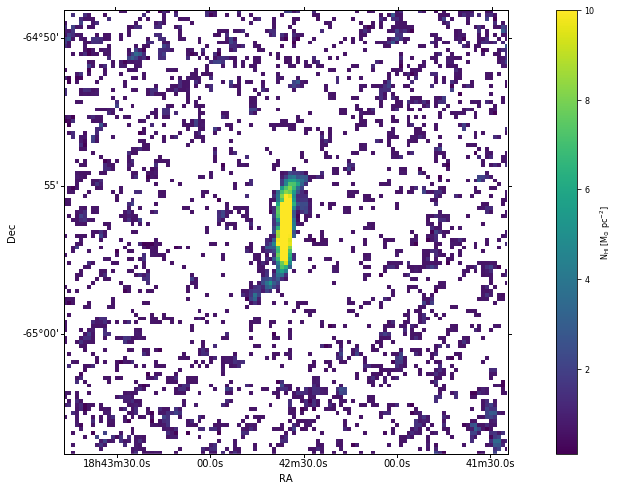

In [58]:
obj = objects[1]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 8.0
    improve_data(obs_collections[obj], obj, proj, cell, 2.0, 
                 'felocity,150,4218,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### NGC6848
The galaxy is hardly detected but the data are fine.

This is object ngc6848
['/data/HI_Interferometry/C801/2000-05-24/ngc6848.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 9.0 arcsec.
The beam size is 34.9 by 26.0 arcsec
A third of the minor axis is 8.7
The weighting is 2.0
The line parameter is felocity,75,3783,16,16


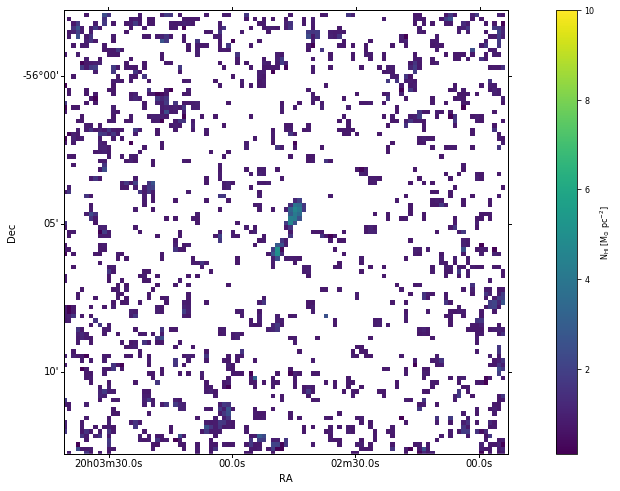

In [59]:
obj = objects[2]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 9.0
    improve_data(obs_collections[obj], obj, proj, cell, 2.0, 
                 'felocity,75,3783,16,16')
cell_size, robust, line = visualise_current(proj, obj)

### IC4757
This is a really cool galaxy but probably not useful for kinematic analysis.

This is object ic4757
['/data/HI_Interferometry/C801/2000-05-23/ic4757.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 8.0 arcsec.
The beam size is 35.1 by 25.6 arcsec
A third of the minor axis is 8.5
The weighting is 2.0
The line parameter is felocity,75,2917,16,16


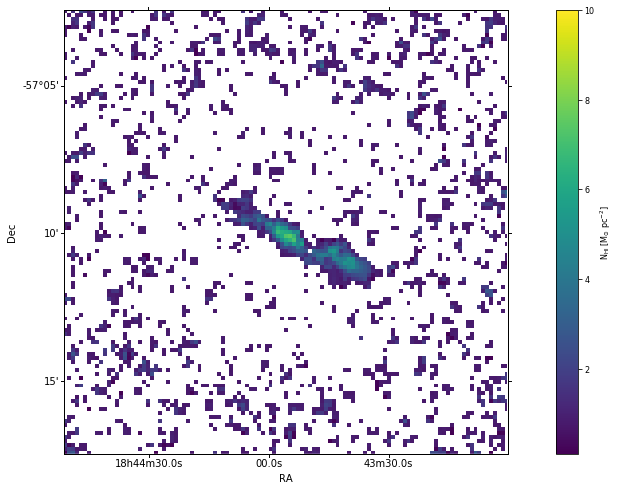

In [60]:
obj = objects[3]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 8.0
    improve_data(obs_collections[obj], obj, proj, cell, 2.0, 
                 'felocity,75,2917,16,16')
cell_size, robust, line = visualise_current(proj, obj)

## C885

In [61]:
objects = ['0121-g6', '116-g12', '123-g23', '240-g11', '269-g19', 
           '287-g13', '79-g14']
proj = projects[9]
print(proj)
print(len(objects))
obs_dates = {
            '2000-05-09': {'phase': '2106-413.1408',
                           'bandpass': '1934-638.1408',
                           'sci_sou':  ['287-g13.1408']},
            '2000-05-10_1': {'phase': '0727-365.1407',
                             'bandpass': '1934-638.1407',
                             'sci_sou':  ['123-g23.1407']},
            '2000-05-10_2': {'phase': '0252-712.1410',
                             'bandpass': '1934-638.1410',
                             'sci_sou':  ['79-g14.1410']},
            '2000-05-11_1': {'phase': '1215-457.1410',
                             'bandpass': '1934-638.1410',
                             'sci_sou':  ['269-g19.1410']},
            '2000-05-11_2': {'phase': '2326-477.1407',
                             'bandpass': '1934-638.1407',
                             'sci_sou':  ['240-g11.1407']},
            '2000-05-12': {'phase': '0407-658.1415',
                           'bandpass': '1934-638.1415',
                           'sci_sou':  ['0121-g6.1415']},
            '2000-05-13': {'phase': '0407-658.1415',
                           'bandpass': '1934-638.1415',
                           'sci_sou':  ['116-g12.1415']},
            '2001-07-28': {'phase': '2326-477.1407',
                           'bandpass': '1934-638.1407',
                           'sci_sou':  ['240-g11.1407']},
            '2001-07-29_1': {'phase': '2326-477.1407',
                             'bandpass': '1934-638.1407',
                             'sci_sou':  ['240-g11.1407']},
            '2001-07-29_2': {'phase': '1215-457.1410',
                             'bandpass': '0823-500.1410',
                             'sci_sou':  ['269-g19.1410']},
            '2001-07-29_3': {'phase': '0407-658.1415',
                             'bandpass': '1934-638.1415',
                             'sci_sou':  ['116-g12.1415']},
            '2001-07-30': {'phase': '0407-658.1415',
                           'bandpass': '1934-638.1415',
                           'sci_sou':  ['0121-g6.1415']},
            '2001-08-03': {'phase': '0727-365.1407',
                           'bandpass': '1934-638.1407',
                           'sci_sou':  ['123-g23.1407']},
            '2001-10-27': {'phase': '0252-712.1410',
                           'bandpass': '1934-638.1410',
                           'sci_sou':  ['79-g14.1410']},
            '2001-10-28': {'phase': '2106-413.1408',
                           'bandpass': '1934-638.1408',
                           'sci_sou':  ['287-g13.1408']}
                   }
obs_collections = sort_data(obs_dates)

C885
7


### ESO121-6
The data are fine and the galaxy will be used for the kinematic analysis.

This is object 0121-g6
['/data/HI_Interferometry/C885/2000-05-12/0121-g6.uvlin', '/data/HI_Interferometry/C885/2001-07-30/0121-g6.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 10.0 arcsec.
The beam size is 49.6 by 30.6 arcsec
A third of the minor axis is 10.2
The weighting is 2.0
The line parameter is felocity,150,559,8,8


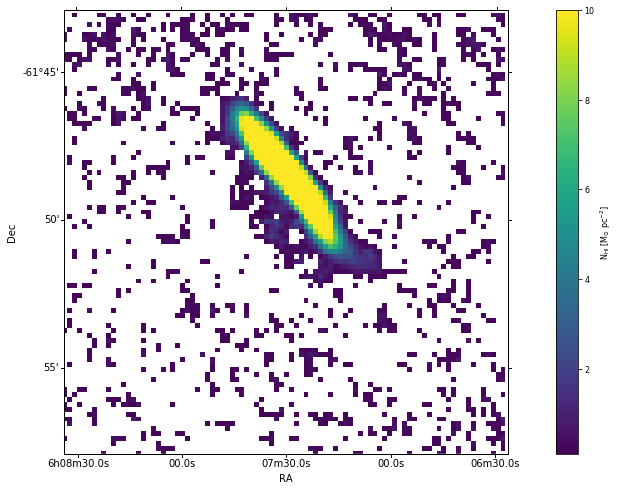

In [62]:
obj = objects[0]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 10.0
    improve_data(obs_collections[obj], obj, proj, cell, 2.0, 
                 'felocity,150,559,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### ESO116-12
The data are fine and the galaxy will be used for the kinematic analysis.

This is object 116-g12
['/data/HI_Interferometry/C885/2001-07-29_3/116-g12.uvlin', '/data/HI_Interferometry/C885/2000-05-13/116-g12.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 12.0 arcsec.
The beam size is 45.4 by 36.5 arcsec
A third of the minor axis is 12.2
The weighting is 2.0
The line parameter is felocity,150,559,8,8


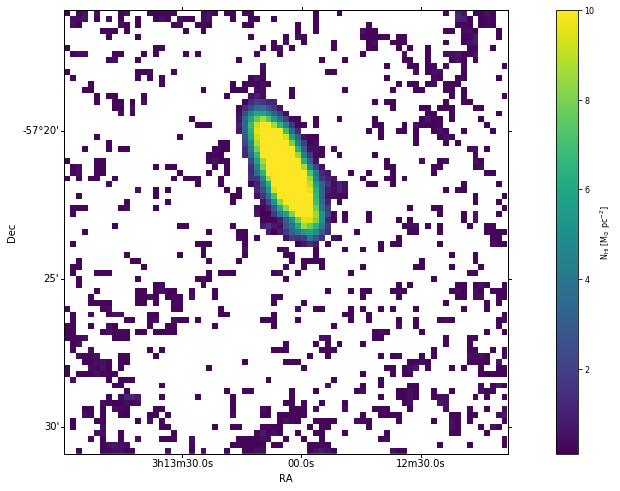

In [63]:
obj = objects[1]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 12.0
    improve_data(obs_collections[obj], obj, proj, cell, 2.0, 
                 'felocity,150,559,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### ESO123-23
The data are fine and the galaxy will be used for the kinematic analysis.

This is object 123-g23
['/data/HI_Interferometry/C885/2001-08-03/123-g23.uvlin', '/data/HI_Interferometry/C885/2000-05-10_1/123-g23.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 11.0 arcsec.
The beam size is 57.1 by 33.9 arcsec
A third of the minor axis is 11.3
The weighting is 2.0
The line parameter is felocity,150,2270,8,8


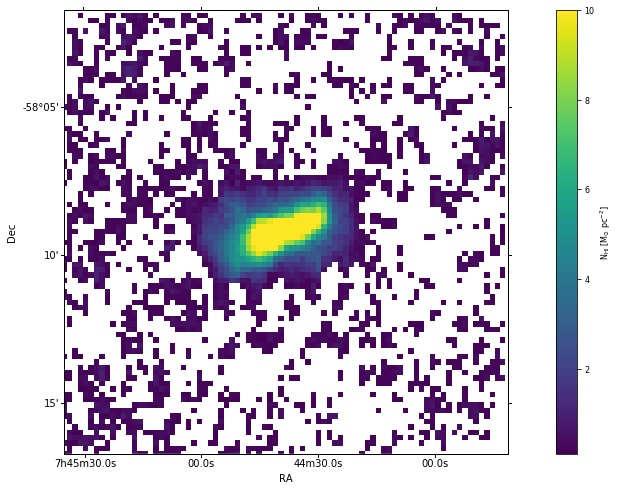

In [64]:
obj = objects[2]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 11.0
    improve_data(obs_collections[obj], obj, proj, cell, 2.0, 
                 'felocity,150,2270,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### ESO240-11
The data are fine and the galaxy will be used for the kinematic analysis.

This is object 240-g11
['/data/HI_Interferometry/C885/2001-07-29_1/240-g11.uvlin', '/data/HI_Interferometry/C885/2001-07-28/240-g11.uvlin', '/data/HI_Interferometry/C885/2000-05-11_2/240-g11.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 12.0 arcsec.
The beam size is 53.3 by 38.7 arcsec
A third of the minor axis is 12.9
The weighting is 2.0
The line parameter is felocity,150,2270,8,8


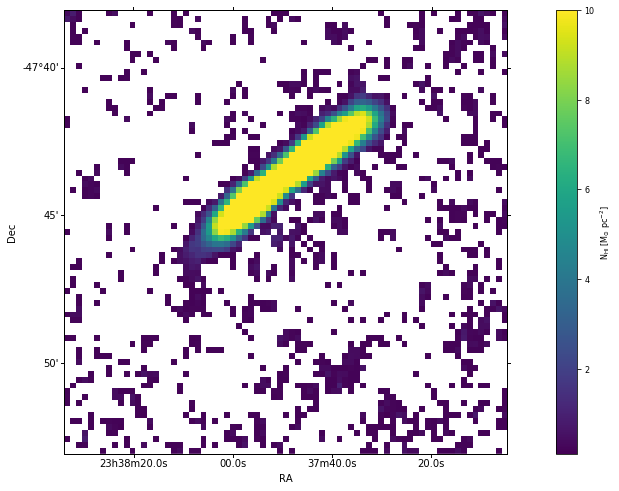

In [65]:
obj = objects[3]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 12.0
    improve_data(obs_collections[obj], obj, proj, cell, 2.0, 
                 'felocity,150,2270,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### ESO269-19
The data are fine and the galaxy will be used for the kinematic analysis.

This is object 269-g19
['/data/HI_Interferometry/C885/2000-05-11_1/269-g19.uvlin', '/data/HI_Interferometry/C885/2001-07-29_2/269-g19.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 10.0 arcsec.
The beam size is 63.3 by 31.8 arcsec
A third of the minor axis is 10.6
The weighting is 2.0
The line parameter is felocity,150,1626,8,8


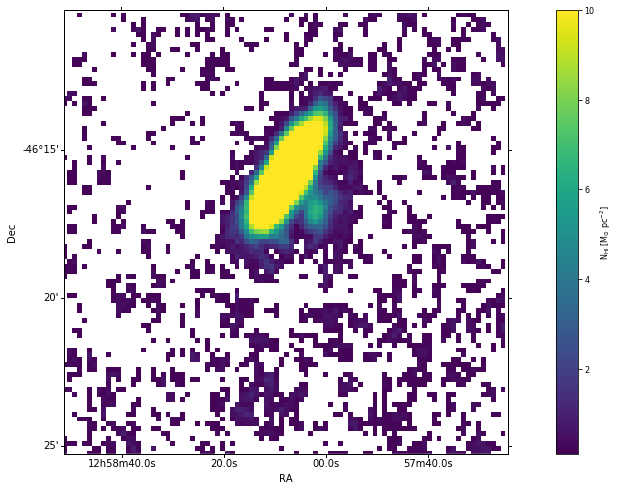

In [66]:
obj = objects[4]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 10.0
    improve_data(obs_collections[obj], obj, proj, cell, 2.0, 
                 'felocity,150,1626,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### ESO287-13
The data are fine and the galaxy will be used for the kinematic analysis.

This is object 287-g13
['/data/HI_Interferometry/C885/2000-05-09/287-g13.uvlin', '/data/HI_Interferometry/C885/2001-10-28/287-g13.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 10.0 arcsec.
The beam size is 38.8 by 30.2 arcsec
A third of the minor axis is 10.1
The weighting is 0.5
The line parameter is felocity,150,2055,8,8


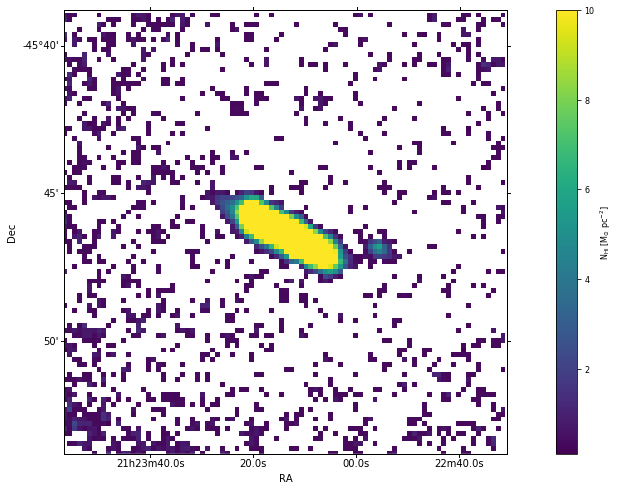

In [67]:
obj = objects[5]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 10.0
    improve_data(obs_collections[obj], obj, proj, cell, 0.5, 
                 'felocity,150,2055,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### ESO79-14
The data are fine and the galaxy will be used for the kinematic analysis.

This is object 79-g14
['/data/HI_Interferometry/C885/2000-05-10_2/79-g14.uvlin', '/data/HI_Interferometry/C885/2001-10-27/79-g14.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 10.0 arcsec.
The beam size is 33.3 by 29.2 arcsec
A third of the minor axis is 9.7
The weighting is 0.5
The line parameter is felocity,150,1626,8,8


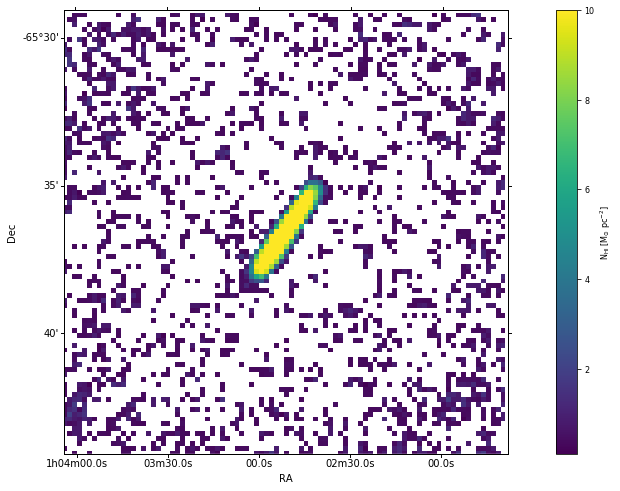

In [68]:
obj = objects[6]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 10.0
    improve_data(obs_collections[obj], obj, proj, cell, 0.5, 
                 'felocity,150,1626,8,8')
cell_size, robust, line = visualise_current(proj, obj)

## C1046

In [69]:
objects = []
proj = projects[10]
print(proj)
print(len(objects))
obs_dates = {}
obs_collections = sort_data(obs_dates)

C1046
0


## C529

In [70]:
objects = ['364g29', 'ic2531', 'ic5096', 'ngc1886', 'ngc2788a', 
           'eso240g11', 'ngc5084', 'ngc5102', 'ngc6722', 'ngc6771', 'ngc3390']
proj = projects[12]
print(proj)
print(len(objects))
obs_dates = {
            '96-04-04': {'phase': '0606-795.1401',
                         'bandpass': '1934-638.1401',
                         'sci_sou':  ['ngc2788a.1401']},
            '96-04-06': {'phase': '1055-242.1409',
                         'bandpass': '1934-638.1409',
                         'sci_sou':  ['ic2531.1409']},
            '96-04-08': {'phase': '1015-314.1407',
                         'bandpass': '1934-638.1407',
                         'sci_sou':  ['ngc3390.1407']},
            '96-09-13_1': {'phase': '1934-638.1401',
                           'bandpass': '1934-638.1401',
                           'sci_sou':  ['ngc6771.1401']},
            '96-09-13_2': {'phase': '1055-242.1409',
                           'bandpass': '1934-638.1409',
                           'sci_sou':  ['ic2531.1409']},
            '96-09-15_1': {'phase': '1934-638.1399',
                           'bandpass': '1934-638.1399',
                           'sci_sou':  ['ngc6722.1399']},
            '96-09-15_2': {'phase': '0445-221.1412',
                           'bandpass': '1934-638.1412',
                           'sci_sou':  ['ngc1886.1412']},
            '96-09-16': {'phase': '2327-459.1407',
                         'bandpass': '1934-638.1407',
                         'sci_sou':  ['eso240g11.1407']},
            '96-12-10': {'phase': '1934-638.1406',
                         'bandpass': '1934-638.1406',
                         'sci_sou':  ['ic5096.1406']},
            '97-03-03': {'phase': '2327-459.1407',
                         'bandpass': '1934-638.1407',
                         'sci_sou':  ['eso240g11.1407']},
            '97-03-04_1': {'phase': '1245-197.1412',
                           'bandpass': '1934-638.1412',
                           'sci_sou':  ['ngc5084.1412']},
            '97-03-04_2': {'phase': '1934-638.1401',
                           'bandpass': '1934-638.1401',
                           'sci_sou':  ['ngc6771.1401']},
            '97-03-04_3': {'phase': '1934-638.1401',
                           'bandpass': '1934-638.1401',
                           'sci_sou':  ['ngc6771.1401']},
            '97-03-06': {'phase': '1232-416.1418',
                         'bandpass': '1934-638.1418',
                         'sci_sou':  ['ngc5102.1418']},
            '97-03-07_1': {'phase': '1055-242.1409',
                           'bandpass': '1934-638.1409',
                           'sci_sou':  ['ic2531.1409']},
            '97-03-07_2': {'phase': '1934-638.1401',
                           'bandpass': '1934-638.1401',
                           'sci_sou':  ['ngc6771.1401']},
            '97-03-08_1': {'phase': '0614-349.1417',
                           'bandpass': '1934-638.1417',
                           'sci_sou':  ['364g29.1417']},
            '97-03-08_2': {'phase': '1245-197.1412',
                           'bandpass': '1934-638.1412',
                           'sci_sou':  ['ngc5084.1412']},
            '97-03-09_1': {'phase': '2327-459.1407',
                           'bandpass': '1934-638.1407',
                           'sci_sou':  ['eso240g11.1407']},
            '97-03-09_2': {'phase': '0614-349.1417',
                           'bandpass': '1934-638.1417',
                           'sci_sou':  ['364g29.1417']},
            '97-05-22': {'phase': '1245-197.1412',
                         'bandpass': '1934-638.1412',
                         'sci_sou':  ['ngc5084.1412']}
                   }
obs_collections = sort_data(obs_dates)

C529
11


### ESO364-29
The data are fine and will be used for the kinematic analysis. 

This is object 364g29
['/data/HI_Interferometry/C529/97-03-09_2/364g29.uvlin', '/data/HI_Interferometry/C529/97-03-08_1/364g29.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 7.0 arcsec.
The beam size is 76.8 by 20.9 arcsec
A third of the minor axis is 7.0
The weighting is 2.0
The line parameter is felocity,150,135,8,8


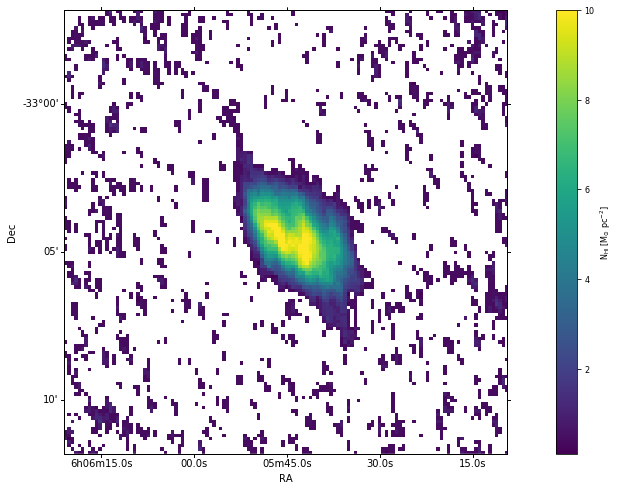

In [71]:
obj = objects[0]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 7.0
    improve_data(obs_collections[obj], obj, proj, cell, 2.0, 
                 'felocity,150,135,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### IC2531
The data are fine and will be used for the kinematic analysis. 

This is object ic2531
['/data/HI_Interferometry/C529/96-09-13_2/ic2531.uvlin', '/data/HI_Interferometry/C529/96-04-06/ic2531.uvlin', '/data/HI_Interferometry/C529/97-03-07_1/ic2531.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 6.0 arcsec.
The beam size is 39.7 by 17.2 arcsec
A third of the minor axis is 5.7
The weighting is 2.0
The line parameter is felocity,150,1841,8,8


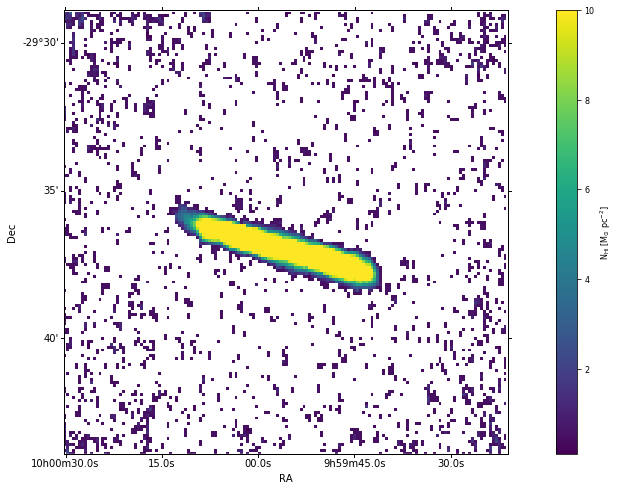

In [72]:
obj = objects[1]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 6.0
    improve_data(obs_collections[obj], obj, proj, cell, 2.0, 
                 'felocity,150,1841,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### IC5096
The galaxy is not detected. 

### NGC1886
The galaxy is not detected.

### NGC2788a
The galaxy is not detected. 

### ESO240-11
The data are fine and will be used in the kinematic analysis.

This is object eso240g11
['/data/HI_Interferometry/C529/97-03-03/eso240g11.uvlin', '/data/HI_Interferometry/C529/96-09-16/eso240g11.uvlin', '/data/HI_Interferometry/C529/97-03-09_1/eso240g11.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 6.0 arcsec.
The beam size is 24.3 by 17.8 arcsec
A third of the minor axis is 5.9
The weighting is 2.0
The line parameter is felocity,150,2270,8,8


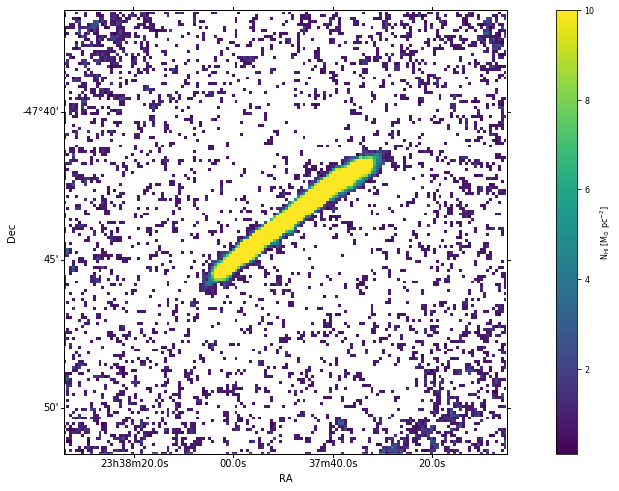

In [73]:
obj = objects[5]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 6.0
    improve_data(obs_collections[obj], obj, proj, cell, 2.0, 
                 'felocity,150,2270,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### NGC5084
The data are fine and will be used in the kinematic analysis.

This is object ngc5084
['/data/HI_Interferometry/C529/97-03-04_1/ngc5084.uvlin', '/data/HI_Interferometry/C529/97-03-08_2/ngc5084.uvlin', '/data/HI_Interferometry/C529/97-05-22/ngc5084.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 6.0 arcsec.
The beam size is 53.9 by 18.5 arcsec
A third of the minor axis is 6.2
The weighting is 2.0
The line parameter is felocity,150,1199,8,8


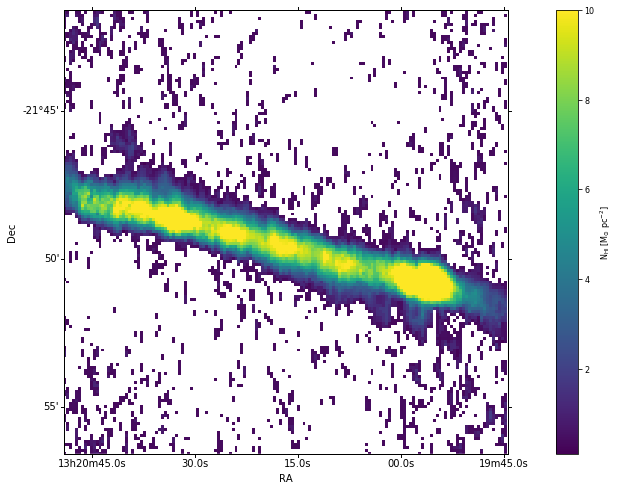

In [74]:
obj = objects[6]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 6.0
    improve_data(obs_collections[obj], obj, proj, cell, 2.0, 
                 'felocity,150,1199,8,8', imsize=round(25. * 60. / cell))
cell_size, robust, line = visualise_current(proj, obj)

### NGC6722
The actual galaxy NGC6722 is outside of the HPBW, but there might be two blobbs of HI in the centre of the image --> very interesting. 

This is object ngc6722
['/data/HI_Interferometry/C529/96-09-15_1/ngc6722.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 5.0 arcsec.
The beam size is 16.8 by 14.4 arcsec
A third of the minor axis is 4.8
The weighting is 2.0
The line parameter is felocity,75,4000,16,16


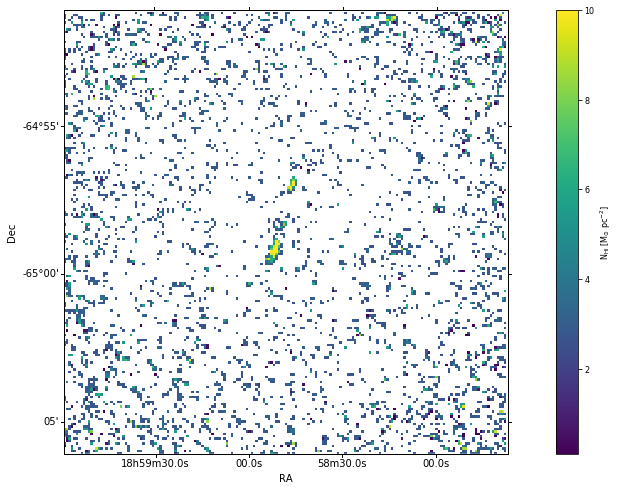

In [75]:
obj = objects[8]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    cell = 5.0
    improve_data(obs_collections[obj], obj, proj, cell, 2.0, 
                 'felocity,75,4000,16,16')
cell_size, robust, line = visualise_current(proj, obj)

### NGC6771
NGC6771 is not detected in HI but a neighbouring interacting galaxy pair (NGC6770 and NGC6769) have some HI between them and there is some more HI detected at the north-western edge of NGC6769.

This is object ngc6771
['/data/HI_Interferometry/C529/96-09-13_1/ngc6771.uvlin', '/data/HI_Interferometry/C529/97-03-04_2/ngc6771.uvlin', '/data/HI_Interferometry/C529/97-03-04_3/ngc6771.uvlin', '/data/HI_Interferometry/C529/97-03-07_2/ngc6771.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 6.0 arcsec.
The beam size is 21.4 by 17.8 arcsec
A third of the minor axis is 5.9
The weighting is 2.0
The line parameter is felocity,150,3566,8,8


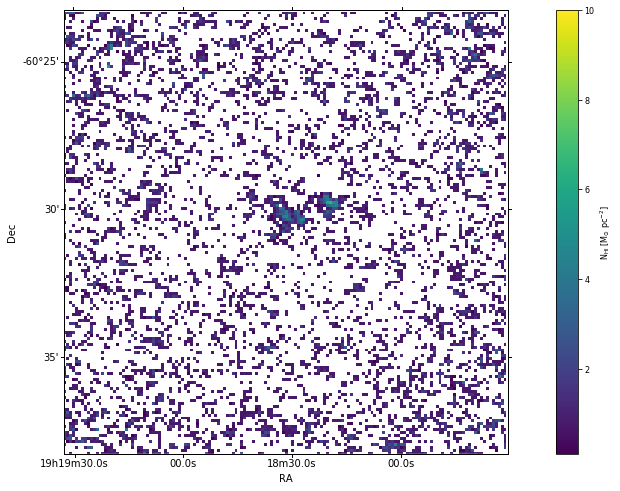

In [76]:
obj = objects[9]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    improve_data(obs_collections[obj], obj, proj, 6.0, 2.0, 
                 'felocity,150,3566,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### NGC3390
The galaxy is not detected.

## C531

In [77]:
objects = ['148-ig10', '157-ig05', '205-g01', '249-ig31', '342-ig13']
proj = projects[13]
print(proj)
print(len(objects))
obs_dates = {
            '96-04-20': {'phase': '0537-441.1414',
                         'bandpass': '1934-638.1414',
                         'sci_sou':  ['205-g01.1414']},
            '96-04-23': {'phase': '0407-658.1414',
                         'bandpass': '1934-638.1414',
                         'sci_sou':  ['157-ig05.1414']},
            '96-04-24': {'phase': '2106-413.1406',
                         'bandpass': '1934-638.1406',
                         'sci_sou':  ['342-ig13.1406']},
            '96-04-25': {'phase': '2310-417.1404',
                         'bandpass': '1934-638.1404',
                         'sci_sou':  ['148-ig10.1404']},
            '96-04-27': {'phase': '0537-441.1416',
                         'bandpass': '1934-638.1416',
                         'sci_sou':  ['249-ig31.1416']},
            '97-04-27': {'phase': '0438-436.1416',
                         'bandpass': '1934-638.1416',
                         'sci_sou':  ['249-ig31.1416']},
            '97-04-28_1': {'phase': '2058-425.1406',
                           'bandpass': '1934-638.1406',
                           'sci_sou':  ['342-ig13.1406']},
            '97-04-28_2': {'phase': '2106-413.1406',
                           'bandpass': '1934-638.1406',
                           'sci_sou':  ['342-ig13.1406']},
            '97-05-01': {'phase': '0407-658.1414',
                         'bandpass': '1934-638.1414',
                         'sci_sou':  ['157-ig05.1414']},
            '97-05-30_1': {'phase': '2106-413.1406',
                           'bandpass': '1934-638.1406',
                           'sci_sou':  ['342-ig13.1406']},
            '97-05-30_2': {'phase': '2259-375.1406',
                           'bandpass': '1934-638.1406',
                           'sci_sou':  ['342-ig13.1406']},
            '97-05-31': {'phase': '0438-436.1416',
                         'bandpass': '1934-638.1416',
                         'sci_sou':  ['249-ig31.1416']},
            '97-06-02': {'phase': '0407-658.1414',
                         'bandpass': '1934-638.1414',
                         'sci_sou':  ['157-ig05.1414']}
                   }
obs_collections = sort_data(obs_dates)

C531
5


### ESO 148-10
The data are fine and there is a detection, but they will not be used for the kinematic analysis. 

This is object 148-ig10
['/data/HI_Interferometry/C531/96-04-25/148-ig10.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 22.0 arcsec.
The beam size is 197.1 by 69.2 arcsec
A third of the minor axis is 23.1
The weighting is 0.5
The line parameter is felocity,150,2917,8,8


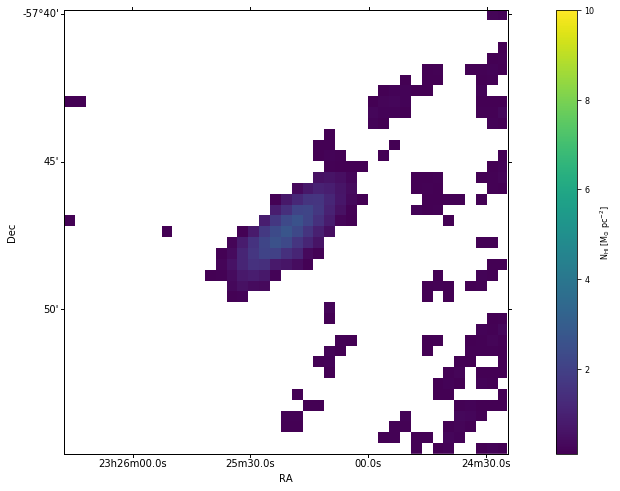

In [78]:
obj = objects[0]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    improve_data(obs_collections[obj], obj, proj, 22.0, 0.5, 
                 'felocity,150,2917,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### ESO 157-5
The data are fine, the galaxy is detected but it is not useful for the kinematic analysis.

This is object 157-ig05
['/data/HI_Interferometry/C531/97-06-02/157-ig05.uvlin', '/data/HI_Interferometry/C531/97-05-01/157-ig05.uvlin', '/data/HI_Interferometry/C531/96-04-23/157-ig05.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 15.0 arcsec.
The beam size is 52.8 by 49.8 arcsec
A third of the minor axis is 16.6
The weighting is 0.5
The line parameter is felocity,150,772,8,8


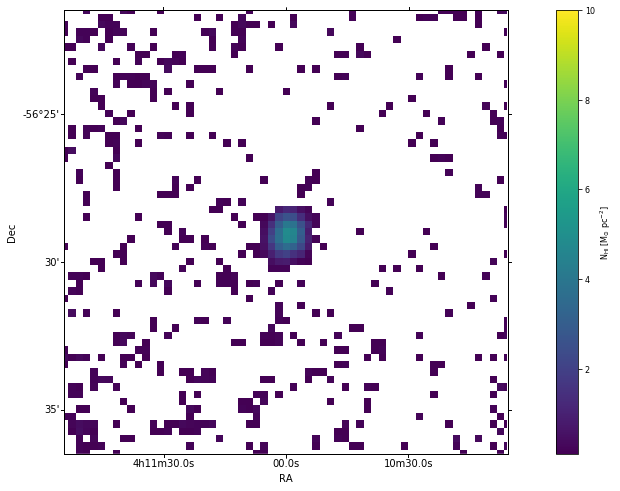

In [79]:
obj = objects[1]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    improve_data(obs_collections[obj], obj, proj, 15.0, 0.5, 
                 'felocity,150,772,8,8', 300)
cell_size, robust, line = visualise_current(proj, obj)

### ESO 205-1
The data are fine and will be used for the kinematic analysis. 

This is object 205-g01
['/data/HI_Interferometry/C531/96-04-20/205-g01.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 30.0 arcsec.
The beam size is 119.4 by 87.9 arcsec
A third of the minor axis is 29.3
The weighting is 0.5
The line parameter is felocity,150,772,8,8


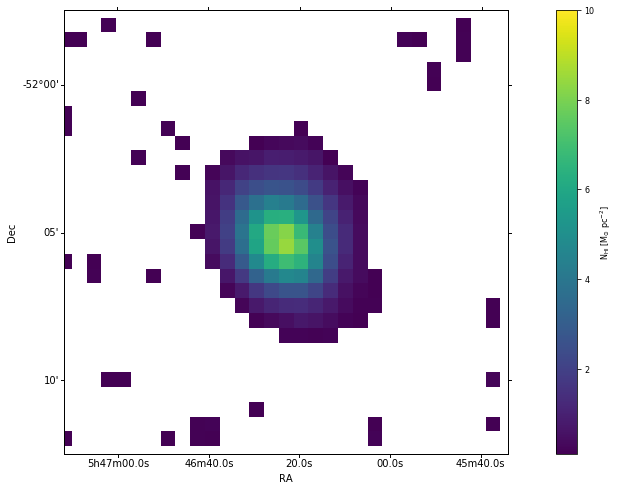

In [80]:
obj = objects[2]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    improve_data(obs_collections[obj], obj, proj, 30.0, 0.5, 
                 'felocity,150,772,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### ESO 249-31
The data are fine and will be used for the kinematic analysis.

This is object 249-ig31
['/data/HI_Interferometry/C531/97-04-27/249-ig31.uvlin', '/data/HI_Interferometry/C531/96-04-27/249-ig31.uvlin', '/data/HI_Interferometry/C531/97-05-31/249-ig31.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 18.0 arcsec.
The beam size is 86.9 by 56.1 arcsec
A third of the minor axis is 18.7
The weighting is 2.0
The line parameter is felocity,150,347,8,8


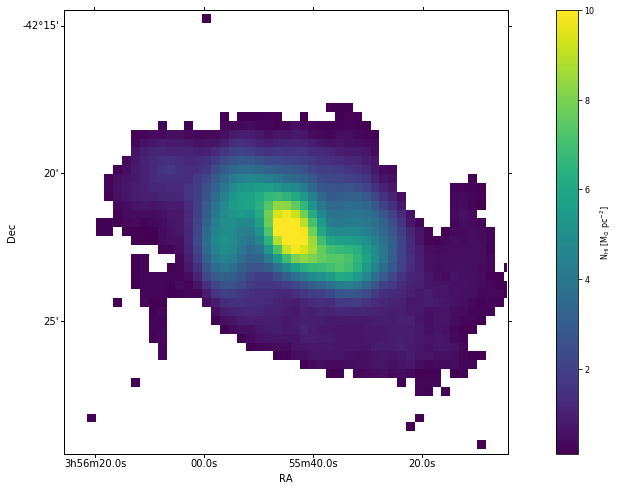

In [81]:
obj = objects[3]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    improve_data(obs_collections[obj], obj, proj, 18.0, 2.0, 
                 'felocity,150,347,8,8', imsize=round(25. * 60. / 18.0))
cell_size, robust, line = visualise_current(proj, obj)

### ESO 342-13
The data are fine but is probably not resolved enough for the kinematic analysis.

This is object 342-ig13
['/data/HI_Interferometry/C531/97-05-30_2/342-ig13.uvlin', '/data/HI_Interferometry/C531/97-05-30_1/342-ig13.uvlin', '/data/HI_Interferometry/C531/97-04-28_2/342-ig13.uvlin', '/data/HI_Interferometry/C531/97-04-28_1/342-ig13.uvlin', '/data/HI_Interferometry/C531/96-04-24/342-ig13.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 17.0 arcsec.
The beam size is 69.2 by 48.9 arcsec
A third of the minor axis is 16.3
The weighting is 0.5
The line parameter is felocity,150,2485,8,8


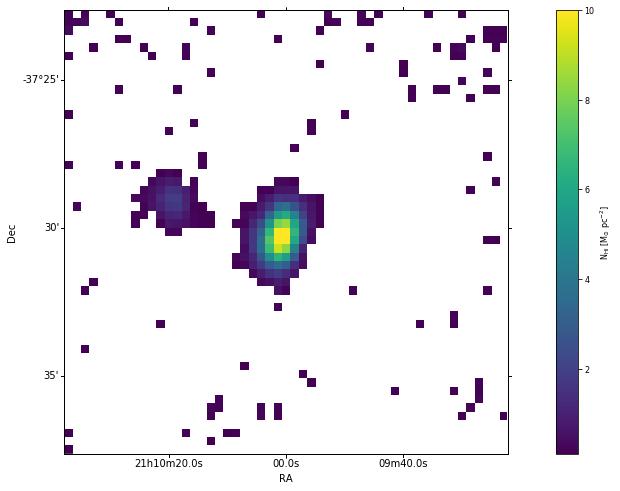

In [82]:
obj = objects[4]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    improve_data(obs_collections[obj], obj, proj, 17.0, 0.5, 
                 'felocity,150,2485,8,8')
cell_size, robust, line = visualise_current(proj, obj)

## C598

In [83]:
objects = ['e324g24', 'e383g87', 'n1427a', 'n5237', 'n5264', 'n5408']
proj = projects[14]
print(proj)
print(len(objects))
obs_dates = {}
obs_collections = sort_data(obs_dates)

C598
6


### NGC1427a

This is object n1427a
The current cell is 13 arcsec.
The beam size is 371.5 by 71.5 arcsec
A third of the minor axis is 23.8
The weighting is 2.0
ATTENTION: beam is very elongated
The line parameter is felocity,150,1412.26080794,8,8


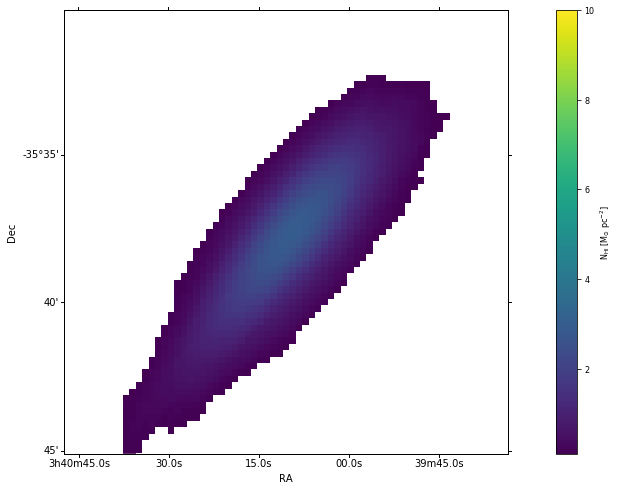

In [84]:
obj = objects[2]
print('This is object {}'.format(obj))
redo_imaging = False
if redo_imaging == True:
    improve_data(obs_collections[obj], obj, proj, 7.0, 0.5, 
                 '', 300)
cell_size, robust, line = visualise_current(proj, obj)

## C616

In [85]:
objects = ['eso185', 'eso338', 'eso480', 'tol3']
proj = projects[15]
print(proj)
print(len(objects))
obs_dates = {}
obs_collections = sort_data(obs_dates)

C616
4


## C705

In [86]:
objects = ['am1342-452', 'cena_15', 'cena_41', '1999-02-06', 'eso294-010', 
           'eso384-016', 'am1339-445', 'scl-de1', 'eso540-030', 'eso540-032', 
           'eso269-066']
proj = projects[16]
print(proj)
print(len(objects))
obs_dates = {
            '1998-04-11': {'phase': '1320-446.1418',
                           'bandpass': '1934-638.1418',
                           'sci_sou':  ['cena_41.1418']},
            '1998-04-14': {'phase': '1320-446.1418',
                           'bandpass': '1934-638.1418',
                           'sci_sou':  ['cena_15.1418']},
            '1998-04-15': {'phase': '1320-446.1418',
                           'bandpass': '1934-638.1418',
                           'sci_sou':  ['cena_15.1418']},
            '1998-12-16': {'phase': '0022-423.1418',
                           'bandpass': '1934-638.1418',
                           'sci_sou':  ['eso294-010.1418']},
            '1998-12-17': {'phase': '0023-263.1418',
                           'bandpass': '1934-638.1418',
                           'sci_sou':  ['scl-de1.1418']},
            '1998-12-18': {'phase': '0023-263.1418',
                           'bandpass': '1934-638.1418',
                           'sci_sou':  ['eso540-032.1418']},
            '1998-12-19': {'phase': '0023-263.1419',
                           'bandpass': '1934-638.1419',
                           'sci_sou':  ['eso540-030.1419']},
            '1999-02-06': {'phase': '1320-446.1418',
                           'bandpass': '1934-638.1418',
                           'sci_sou':  ['eso269-066.1418']},
            '1999-02-07': {'phase': '1320-446.1418',
                           'bandpass': '1934-638.1418',
                           'sci_sou':  ['am1339-445.1418']},
            '1999-02-08': {'phase': '1320-446.1418',
                           'bandpass': '1934-638.1418',
                           'sci_sou':  ['am1342-452.1418']},
            '1999-04-24': {'phase': '1349-439.1418',
                           'bandpass': '1934-638.1418',
                           'sci_sou':  ['eso384-016.1418']}
                   }
obs_collections = sort_data(obs_dates)

C705
11


## C744

In [87]:
objects = ['e124-15', 'e187-35', 'e39-2', 'n986', 'n7661', 'n4930', 'n7098']
proj = projects[17]
print(proj)
print(len(objects))
obs_dates = {
            '1998-12-05_0': {'phase': '2353-686.1410',
                             'bandpass': '1934-638.1410',
                             'sci_sou':  ['n7661.1410']},
            '1998-12-05_1': {'phase': '1320-446.1410',
                            'bandpass': '1934-638.1410',
                            'sci_sou':  ['e39-2.1410', 'n4930.1410']},
            '1998-12-05_2': {'phase': '2106-413.1410',
                             'bandpass': '1934-638.1410',
                             'sci_sou':  ['e187-35.1410']},
            '1998-12-05_3': {'phase': '1036-697.1410',
                             'bandpass': '1934-638.1410',
                             'sci_sou':  ['e124-15.1410']},
            '1998-12-05_4': {'phase': '0153-410.1410',
                            'bandpass': '1934-638.1410',
                            'sci_sou':  ['n986.1410']},
            '1998-12-05_5': {'phase': '2142-758.1410',
                             'bandpass': '1934-638.1410',
                             'sci_sou':  ['n7098.1410']}
                   }
obs_collections = sort_data(obs_dates)

C744
7


### ESO124-15
The data are fine and will be used for the kinematic analysis.

This is object e124-15
['/data/HI_Interferometry/C744/1998-12-05_3/e124-15.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 12.0 arcsec.
The beam size is 50.8 by 38.7 arcsec
A third of the minor axis is 12.9
The weighting is 0.5
The line parameter is felocity,150,1626,8,8


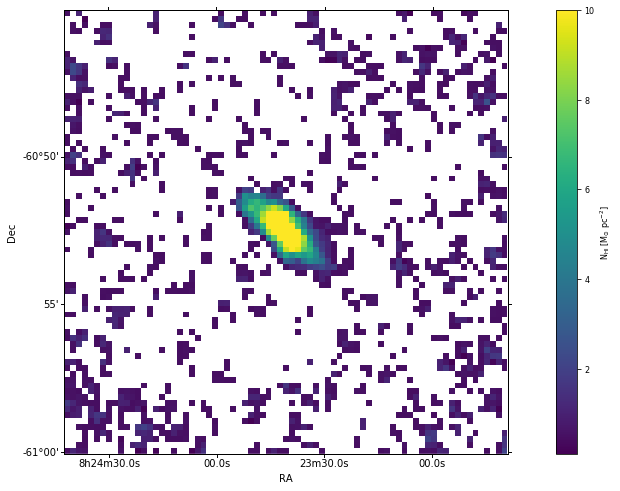

In [88]:
obj = objects[0]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    improve_data(obs_collections[obj], obj, proj, 12.0, 0.5, 
                 'felocity,150,1626,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### ESO187-35
The data are fine and the galaxy is detected but it is too small for the kinematic analysis.

This is object e187-35
['/data/HI_Interferometry/C744/1998-12-05_2/e187-35.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 11.0 arcsec.
The beam size is 61.8 by 35.9 arcsec
A third of the minor axis is 12.0
The weighting is 0.5
The line parameter is felocity,150,1626,8,8


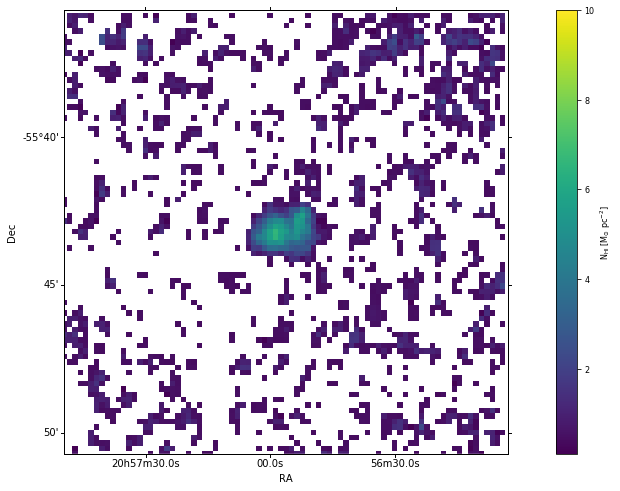

In [89]:
obj = objects[1]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    improve_data(obs_collections[obj], obj, proj, 11.0, 0.5, 
                 'felocity,150,1626,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### ESO39-2
The data are fine and will be used for the kinematic analysis.

This is object e39-2
['/data/HI_Interferometry/C744/1998-12-05_1/e39-2.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 12.0 arcsec.
The beam size is 44.5 by 38.7 arcsec
A third of the minor axis is 12.9
The weighting is 0.5
The line parameter is felocity,150,1626,8,8


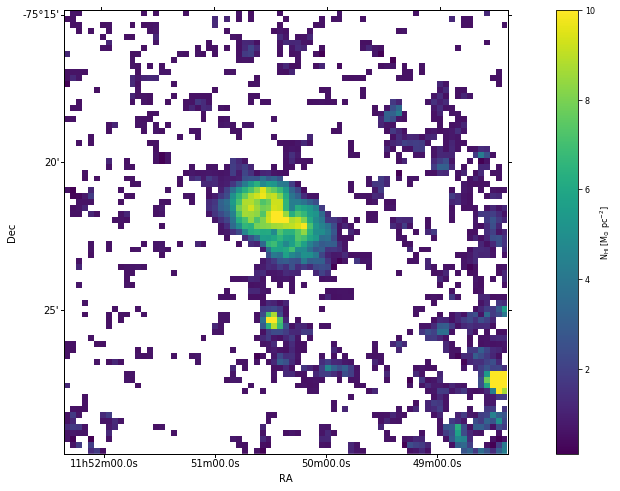

In [90]:
obj = objects[2]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    improve_data(obs_collections[obj], obj, proj, 12.0, 0.5, 
                 'felocity,150,1626,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### NGC986
The data are fine and will be used for the kinematic analysis.

This is object n986
['/data/HI_Interferometry/C744/1998-12-05_4/n986.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 15.0 arcsec.
The beam size is 58.3 by 49.1 arcsec
A third of the minor axis is 16.4
The weighting is 0.5
The line parameter is felocity,150,1626,8,8


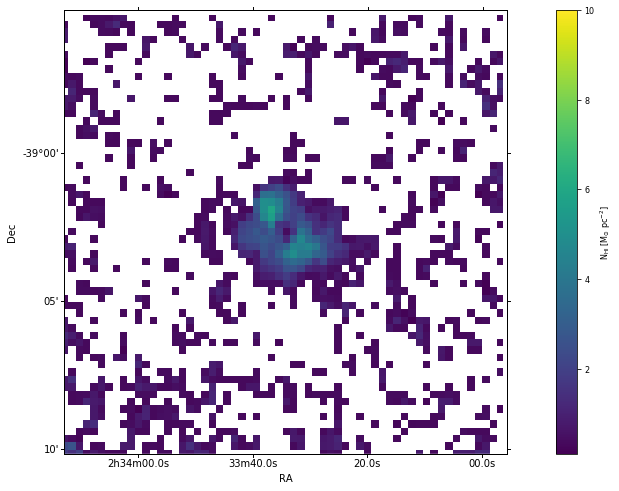

In [91]:
obj = objects[3]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    improve_data(obs_collections[obj], obj, proj, 15.0, 0.5, 
                 'felocity,150,1626,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### NGC7661
The data are fine and the galaxy is detected but it is too small for kinematic analysis.

This is object n7661
['/data/HI_Interferometry/C744/1998-12-05_0/n7661.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 12.0 arcsec.
The beam size is 49.6 by 38.2 arcsec
A third of the minor axis is 12.7
The weighting is 0.5
The line parameter is felocity,150,1626,8,8


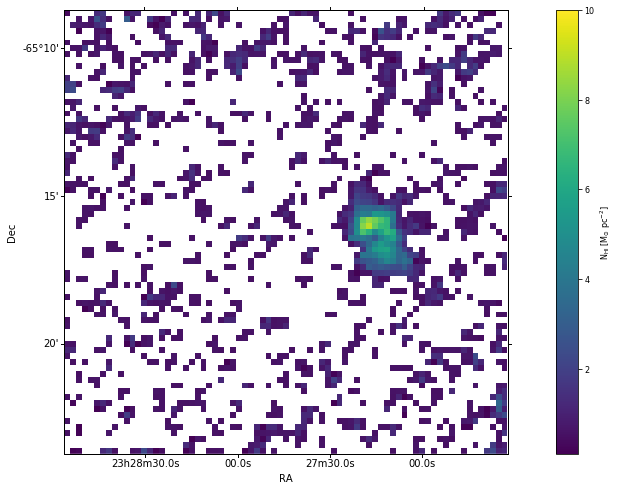

In [92]:
obj = objects[4]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    improve_data(obs_collections[obj], obj, proj, 12.0, 0.5, 
                 'felocity,150,1626,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### NGC4930
The data are fine and will be used for the kinematic analysis.

This is object n4930
['/data/HI_Interferometry/C744/1998-12-05_1/n4930.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 12.0 arcsec.
The beam size is 63.6 by 38.5 arcsec
A third of the minor axis is 12.8
The weighting is 0.5
The line parameter is felocity,150,1626,8,8


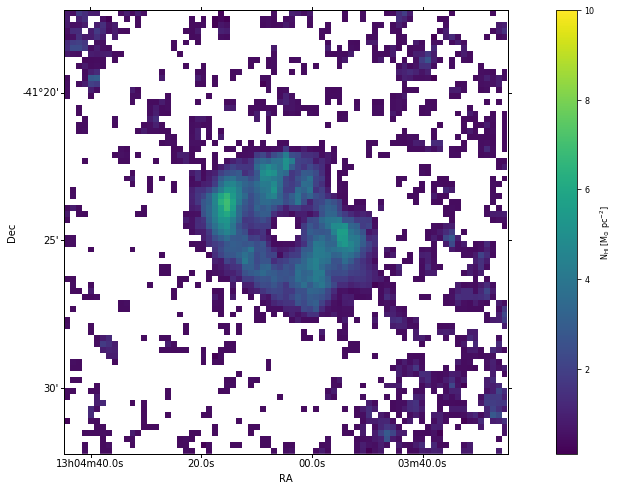

In [93]:
obj = objects[5]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    improve_data(obs_collections[obj], obj, proj, 12.0, 0.5, 
                 'felocity,150,1626,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### NGC7098
The data are fine and will be used in the kinematic analysis. 

This is object n7098
['/data/HI_Interferometry/C744/1998-12-05_5/n7098.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 12.0 arcsec.
The beam size is 88.7 by 38.5 arcsec
A third of the minor axis is 12.8
The weighting is 2.0
The line parameter is felocity,150,1626,8,8


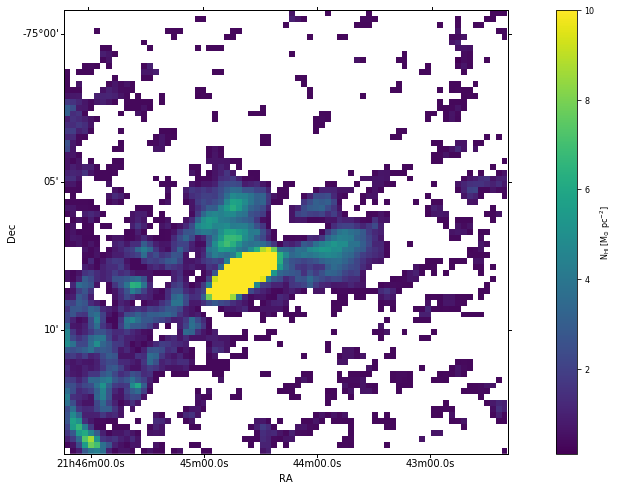

In [94]:
obj = objects[6]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    improve_data(obs_collections[obj], obj, proj, 12.0, 2.0, 
                 'felocity,150,1626,8,8')
cell_size, robust, line = visualise_current(proj, obj)

## C869

In [95]:
objects = ['e315g20', 'e321g10', 'e416g25', 'e435g14', 'e263g15', 'eso564g27', 
           'n5170', 'e446g18', 'e509g19', 'eso142g24', 'eso201g22', 'e435g50']
proj = projects[18]
print(proj)
print(len(objects))
obs_dates = {
            '2000-01-01': {'phase': '0438-436.1401',
                           'bandpass': '1934-638.1401',
                           'sci_sou':  ['eso201g22.1401']},
            '2000-01-08': {'phase': '1934-638.1411',
                           'bandpass': '1934-638.1411',
                           'sci_sou':  ['eso142g24.1411']},
            '2000-01-09': {'phase': '0859-140.1410',
                           'bandpass': '1934-638.1410',
                           'sci_sou':  ['eso564g27.1410']},
            '2000-11-15': {'phase': '0153-410.1397',
                           'bandpass': '1934-638.1397',
                           'sci_sou':  ['e416g25.1397']},
            '2000-11-16': {'phase': '1015-314.1411',
                           'bandpass': '1934-638.1411',
                           'sci_sou':  ['e435g14.1411']},
            '2000-11-17': {'phase': '0823-500.1401',
                           'bandpass': '1934-638.1401',
                           'sci_sou':  ['e315g20.1401']},
            '2001-03-08': {'phase': '1245-197.1413',
                           'bandpass': '1934-638.1413',
                           'sci_sou':  ['n5170.1413']},
            '2001-03-09': {'phase': '1245-197.1370',
                           'bandpass': '0823-500.1370',
                           'sci_sou':  ['e509g19.1370']},
            '2001-03-11': {'phase': '1308-220.1398',
                           'bandpass': '1934-638.1398',
                           'sci_sou':  ['e446g18.1398']},
            '2001-03-12': {'phase': '1243-412.1406',
                           'bandpass': '1934-638.1406',
                           'sci_sou':  ['e321g10.1406']},
            '2001-03-13': {'phase': '1012-44.1397',
                           'bandpass': '1934-638.1397',
                           'sci_sou':  ['e315g20.1397']},
            '2001-03-14': {'phase': '1015-314.1408',
                           'bandpass': '1934-638.1408',
                           'sci_sou':  ['e435g14.1408']},
            '2001-03-15': {'phase': '1039-47.1408',
                           'bandpass': '1934-638.1408',
                           'sci_sou':  ['e263g15.1408']},
            '2001-03-16': {'phase': '1015-314.1408',
                           'bandpass': '1934-638.1408',
                           'sci_sou':  ['e435g14.1408', 'e435g50.1408']}
                   }
obs_collections = sort_data(obs_dates)

C869
12


### ESO321-10
The data are fine but the galaxy is hardly detected.

This is object e321g10
['/data/HI_Interferometry/C869/2001-03-12/e321g10.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 10.0 arcsec.
The beam size is 37.0 by 29.0 arcsec
A third of the minor axis is 9.7
The weighting is 2.0
The line parameter is felocity,150,2485,8,8


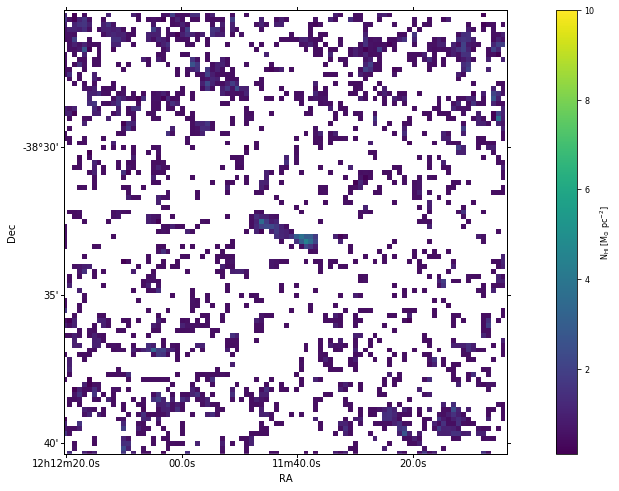

In [96]:
obj = objects[1]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    improve_data(obs_collections[obj], obj, proj, 10.0, 2.0, 
                 'felocity,150,2485,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### ESO416-25
The data are fine but the only detected object is small and near the edge of the HPBW.

This is object e416g25
['/data/HI_Interferometry/C869/2000-11-15/e416g25.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 10.0 arcsec.
The beam size is 59.1 by 29.2 arcsec
A third of the minor axis is 9.7
The weighting is 2.0
The line parameter is felocity,150,4436,8,8


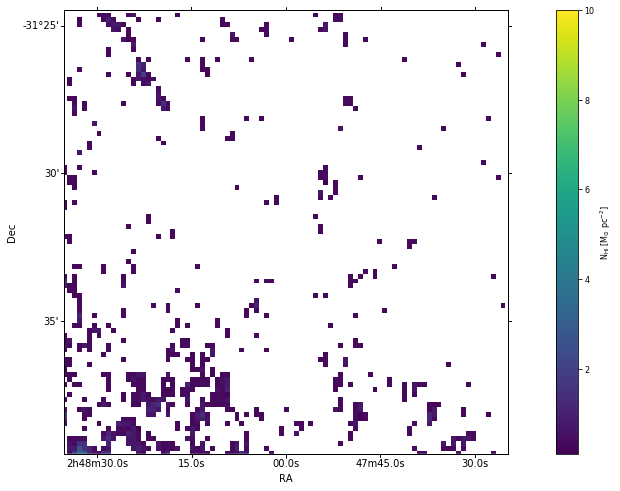

In [97]:
obj = objects[2]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    improve_data(obs_collections[obj], obj, proj, 10.0, 2.0, 
                 'felocity,150,4436,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### ESO435-14
The data are fine and the galaxy is detected but it is too small for the kinematic analysis.

This is object e435g14
['/data/HI_Interferometry/C869/2001-03-14/e435g14.uvlin', '/data/HI_Interferometry/C869/2001-03-16/e435g14.uvlin', '/data/HI_Interferometry/C869/2000-11-16/e435g14.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 10.0 arcsec.
The beam size is 63.7 by 28.0 arcsec
A third of the minor axis is 9.3
The weighting is 2.0
The line parameter is felocity,150,1412,8,8


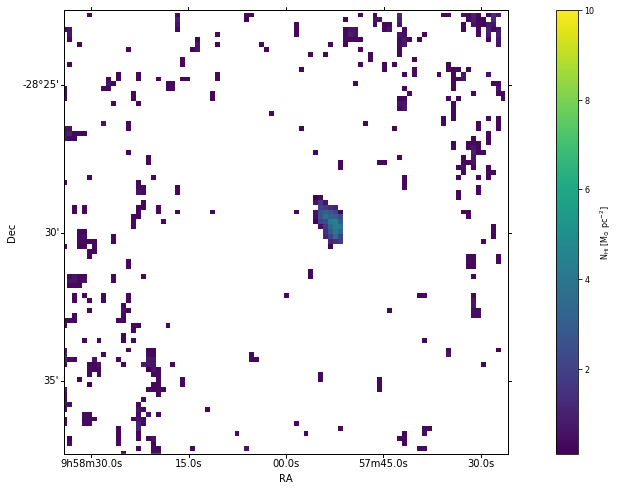

In [98]:
obj = objects[3]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    improve_data(obs_collections[obj], obj, proj, 10.0, 2.0, 
                 'felocity,150,1412,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### ESO263-15
The data are fine, but the galaxy is too small for the kinematic analysis.

This is object e263g15
['/data/HI_Interferometry/C869/2001-03-15/e263g15.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 7.0 arcsec.
The beam size is 25.6 by 22.6 arcsec
A third of the minor axis is 7.5
The weighting is 0.5
The line parameter is felocity,75,2055,16,16


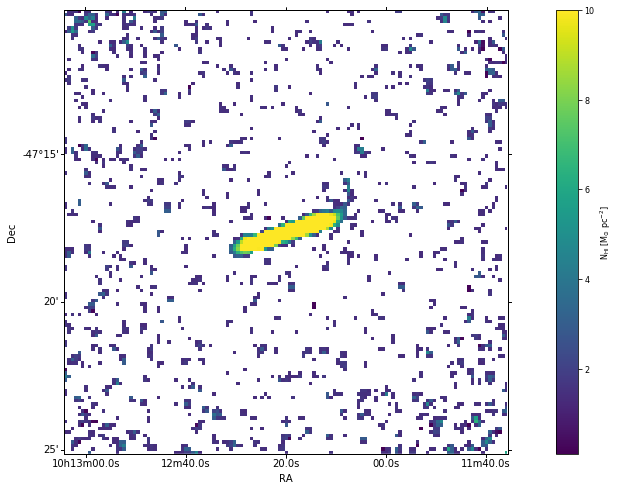

In [99]:
obj = objects[4]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    improve_data(obs_collections[obj], obj, proj, 7.0, 0.5, 
                 'felocity,75,2055,16,16')
cell_size, robust, line = visualise_current(proj, obj)

### ESO564-27
The data are fine and the galaxy will be used in the kinematic analysis.

This is object eso564g27
['/data/HI_Interferometry/C869/2000-01-09/eso564g27.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 8.0 arcsec.
The beam size is 84.9 by 25.4 arcsec
A third of the minor axis is 8.5
The weighting is 2.0
The line parameter is felocity,150,1626,8,8


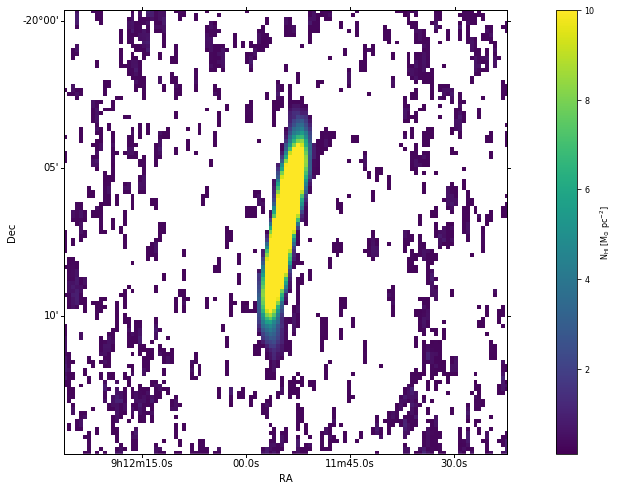

In [100]:
obj = objects[5]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    improve_data(obs_collections[obj], obj, proj, 8.0, 2.0, 
                 'felocity,150,1626,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### NGC5170
The data are fine and the galaxy will be used in the kinematic analysis.

This is object n5170
['/data/HI_Interferometry/C869/2001-03-08/n5170.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 9.0 arcsec.
The beam size is 85.1 by 27.0 arcsec
A third of the minor axis is 9.0
The weighting is 2.0
The line parameter is felocity,150,985,8,8


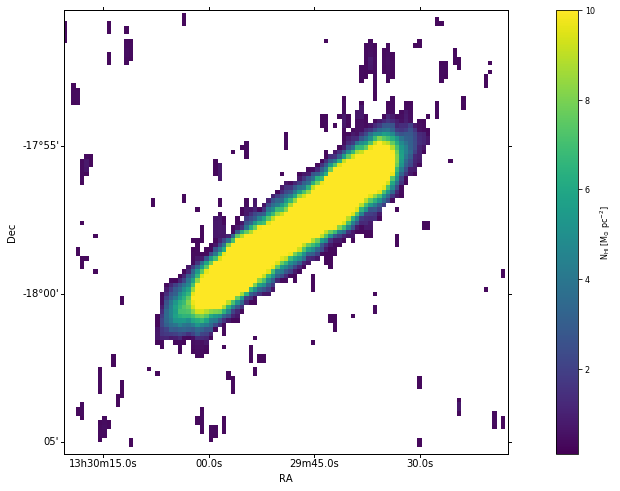

In [101]:
obj = objects[6]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    improve_data(obs_collections[obj], obj, proj, 9.0, 2.0, 
                 'felocity,150,985,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### ESO446-18
The data are fine but the galaxy is too small for the kinematic analysis.

This is object e446g18
['/data/HI_Interferometry/C869/2001-03-11/e446g18.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 7.0 arcsec.
The beam size is 37.4 by 23.0 arcsec
A third of the minor axis is 7.7
The weighting is 0.5
The line parameter is felocity,75,4218,16,16


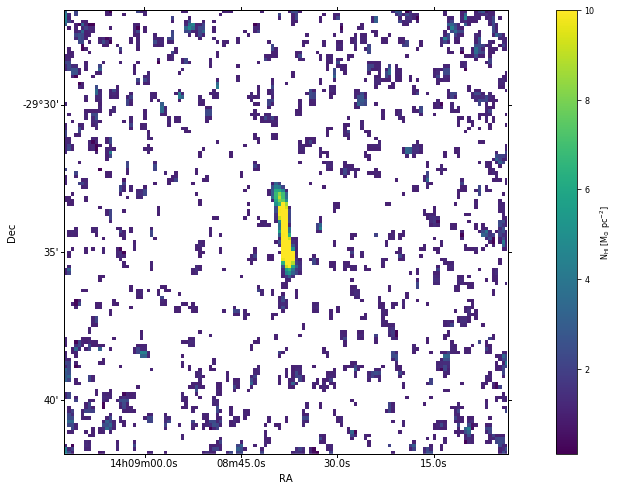

In [102]:
obj = objects[7]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    improve_data(obs_collections[obj], obj, proj, 7.0, 0.5, 
                 'felocity,75,4218,16,16')
cell_size, robust, line = visualise_current(proj, obj)

### ESO142-24
The data are fine and the galaxy will be used in the kinematic analysis.

This is object eso142g24
['/data/HI_Interferometry/C869/2000-01-08/eso142g24.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 9.0 arcsec.
The beam size is 31.3 by 27.3 arcsec
A third of the minor axis is 9.1
The weighting is 2.0
The line parameter is felocity,150,1412,8,8


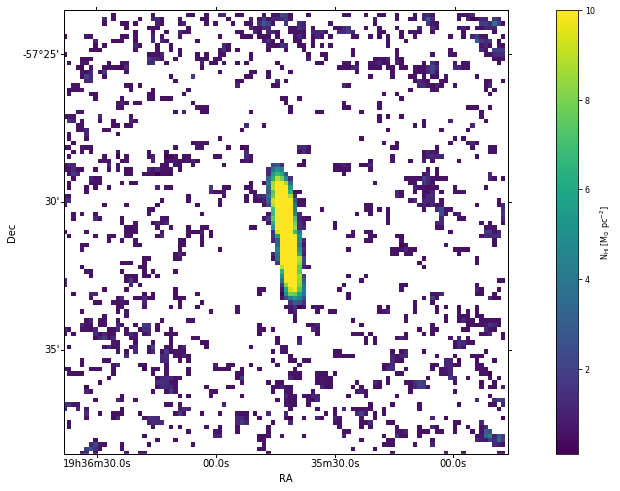

In [103]:
obj = objects[9]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    improve_data(obs_collections[obj], obj, proj, 9.0, 2.0, 
                 'felocity,150,1412,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### ESO201-22
The data are fine and I will try to use it in the kinematic analysis.

This is object eso201g22
['/data/HI_Interferometry/C869/2000-01-01/eso201g22.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 7.0 arcsec.
The beam size is 28.4 by 23.4 arcsec
A third of the minor axis is 7.8
The weighting is 0.5
The line parameter is felocity,75,3566,16,16


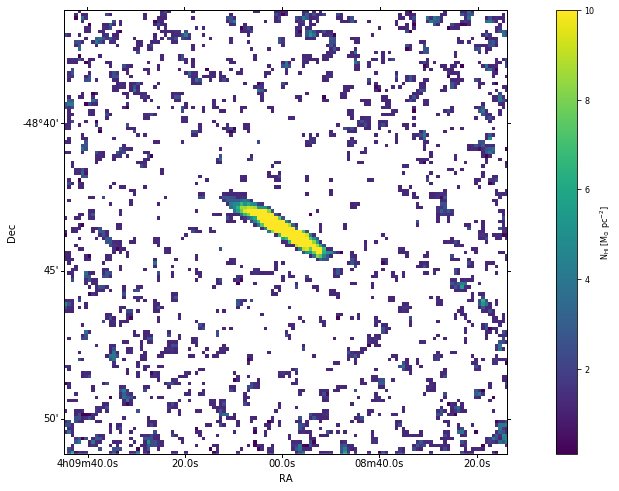

In [104]:
obj = objects[10]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    improve_data(obs_collections[obj], obj, proj, 7.0, 0.5, 
                 'felocity,75,3566,16,16')
cell_size, robust, line = visualise_current(proj, obj)

### ESO435-50
The data are fine but the galaxy is too small for the kinematic analysis.

This is object e435g50
['/data/HI_Interferometry/C869/2001-03-16/e435g50.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 7.0 arcsec.
The beam size is 40.1 by 23.7 arcsec
A third of the minor axis is 7.9
The weighting is 0.5
The line parameter is felocity,75,2055,16,16


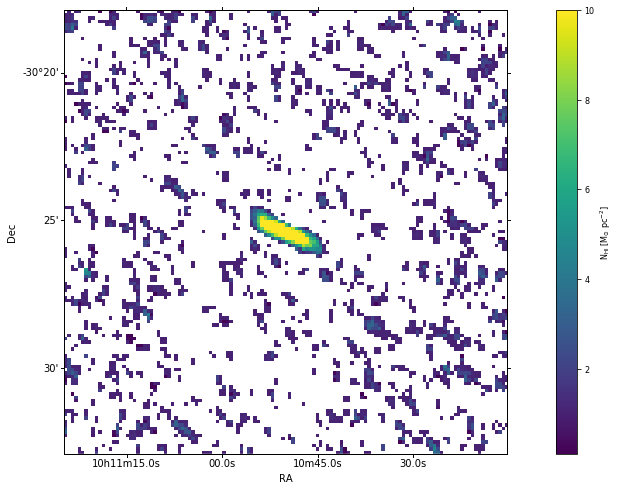

In [105]:
obj = objects[11]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    improve_data(obs_collections[obj], obj, proj, 7.0, 0.5, 
                 'felocity,75,2055,16,16')
cell_size, robust, line = visualise_current(proj, obj)

## C894

In [106]:
objects = ['e115-g21', 'eso107-g16', 'eso138-g14', 'eso274-g01', 'fgc1403', 
           'fgc853', 'fgc998', 'fgce1025', 'fgce1119', 'fgce1216', 'fgce1237', 
           'fgce1317', 'fgce1382', 'fgce1450', 'fgce1564', 'fgce1683', 
           'fgce1709', 'fgce1835', 'fgce187', 'fgce505', 'fgce506', 'fgce624', 
           'fgce714', 'fgce722', 'fgce749', 'fgce755', 'fgce850', 'fgce968', 
           'ic2531', 'ic5052', 'ic5249', 'ugc711']
proj = projects[19]
print(proj)
print(len(objects))
obs_dates = {
            '2000-05-28_1': {'phase': '0823-500.1407',
                             'bandpass': '1934-638.1407',
                             'sci_sou':  ['fgce714.1407']},
            '2000-05-28_2': {'phase': '0537-441.1402',
                             'bandpass': '1934-638.1402',
                             'sci_sou':  ['fgce505.1402']},
            '2000-05-28_3': {'phase': '1305-668.1397',
                             'bandpass': '1934-638.1397',
                             'sci_sou':  ['fgce1025.1397']},
            '2000-05-28_4': {'phase': '0642-349.1407',
                             'bandpass': '1934-638.1407',
                             'sci_sou':  ['fgce624.1407']},
            '2000-05-28_6': {'phase': '1349-439.1401',
                             'bandpass': '1934-638.1401',
                             'sci_sou':  ['fgce1119.1401']},
            '2000-05-29_1': {'phase': '0956-40.1404',
                             'bandpass': '1934-638.1404',
                             'sci_sou':  ['fgce1216.1404', 'fgce749.1404']},
            '2000-05-29_2': {'phase': '2000-330.1407',
                             'bandpass': '1934-638.1407',
                             'sci_sou':  ['fgce1450.1407']},
            '2000-05-29_3': {'phase': '0153-410.1382',
                             'bandpass': '1934-638.1382',
                             'sci_sou':  ['fgce187.1382']},
            '2000-05-29_4': {'phase': '2333-528.1405',
                             'bandpass': '1934-638.1405',
                             'sci_sou':  ['fgce1835.1405']},
            '2000-05-29_5': {'phase': '0906-47.1410',
                             'bandpass': '1934-638.1410',
                             'sci_sou':  ['fgc853.1410']},
            '2000-05-29_6': {'phase': '0530-727.1400',
                             'bandpass': '1934-638.1400',
                             'sci_sou':  ['fgce506.1400']},
            '2000-05-30_1': {'phase': '1057-797.1400',
                             'bandpass': '0823-500.1400',
                             'sci_sou':  ['fgce850.1400']},
            '2000-05-30_2': {'phase': '1903-802.1390',
                             'bandpass': '0823-500.1390',
                             'sci_sou':  ['fgce1317.1390']},
            '2000-05-30_3': {'phase': '2000-330.1407',
                             'bandpass': '1934-638.1407',
                             'sci_sou':  ['fgce1450.1407']},
            '2000-05-30_5': {'phase': '1610-771.1387',
                             'bandpass': '1934-638.1387',
                             'sci_sou':  ['fgce1237.1387']},
            '2000-05-30_6': {'phase': '2211-388.1410',
                             'bandpass': '1934-638.1410',
                             'sci_sou':  ['fgce1683.1410']},
            '2000-11-18_1': {'phase': '1954-388.1407',
                             'bandpass': '1934-638.1407',
                             'sci_sou':  ['fgce1450.1407']},
            '2000-11-18_2': {'phase': '1950-613.1411',
                             'bandpass': '1934-638.1411',
                             'sci_sou':  ['fgce1382.1411']},
            '2000-11-21_1': {'phase': '1057-797.1405',
                             'bandpass': '1934-638.1405',
                             'sci_sou':  ['fgce755.1405']},
            '2000-11-21_2': {'phase': '1016-311.1410',
                             'bandpass': '1934-638.1410',
                             'sci_sou':  ['fgc853.1410', 'fgce1683.1410']},
            '2000-11-22': {'phase': '1057-797.1404',
                           'bandpass': '1934-638.1404',
                           'sci_sou':  ['fgce749.1404']},
            '2000-11-23_1': {'phase': '1950-613.1411',
                             'bandpass': '1934-638.1411',
                             'sci_sou':  ['fgce1382.1411']},
            '2000-11-23_2': {'phase': '1954-388.1407',
                             'bandpass': '1934-638.1407',
                             'sci_sou':  ['fgce1450.1407']},
            '2000-11-23_3': {'phase': '2211-388.1410',
                             'bandpass': '1934-638.1410',
                             'sci_sou':  ['fgce1683.1410']},
            '2000-11-23_4': {'phase': '1057-797.1405',
                             'bandpass': '0823-500.1405',
                             'sci_sou':  ['fgce755.1405']},
            '2000-11-23_5': {'phase': '1057-797.1404',
                             'bandpass': '1934-638.1404',
                             'sci_sou':  ['fgce749.1404']},
            '2000-11-24_1': {'phase': '0407-658.1400',
                             'bandpass': '0823-500.1400',
                             'sci_sou':  ['fgce506.1400']},
            '2000-11-24_2': {'phase': '1255-316.1413',
                             'bandpass': '1934-638.1413',
                             'sci_sou':  ['fgce1564.1413']},
            '2000-11-24_3': {'phase': '2353-686.1413',
                             'bandpass': '1934-638.1413',
                             'sci_sou':  ['fgce1709.1413']},
            '2000-11-24_4': {'phase': '2326-477.1405',
                             'bandpass': '1934-638.1405',
                             'sci_sou':  ['fgce1835.1405']},
            '2000-12-27_1': {'phase': '1255-316.1413',
                             'bandpass': '0823-500.1413',
                             'sci_sou':  ['fgce1564.1413']},
            '2000-12-28_2': {'phase': '0736-332.1409',
                             'bandpass': '1934-638.1409',
                             'sci_sou':  ['fgce722.1409']},
            '2000-12-28_3': {'phase': '2353-686.1413',
                             'bandpass': '1934-638.1413',
                             'sci_sou':  ['fgce1709.1413']},
            '2000-12-29': {'phase': '2353-686.1413',
                           'bandpass': '1934-638.1413',
                           'sci_sou':  ['fgce1709.1413']},
            '2001-01-11': {'phase': '2353-686.1413',
                           'bandpass': '1934-638.1413',
                           'sci_sou':  ['fgce1709.1413']},
            '2001-05-05': {'phase': '1016-311.1410',
                           'bandpass': '1934-638.1410',
                           'sci_sou':  ['fgc853.1410']},
            '2001-07-28_1': {'phase': '0850-206.1410',
                             'bandpass': '1934-638.1410',
                             'sci_sou':  ['fgc853.1410']},
            '2001-07-28_2': {'phase': '1950-613.1411',
                             'bandpass': '1934-638.1411',
                             'sci_sou':  ['fgce1382.1411']},
            '2001-07-31': {'phase': '2353-686.1413',
                           'bandpass': '1934-638.1413',
                           'sci_sou':  ['fgce1709.1413']},
            '2001-08-02_1': {'phase': '1255-316.1404',
                             'bandpass': '0823-500.1404',
                             'sci_sou':  ['fgce968.1404']},
            '2001-08-02_2': {'phase': '1036-697.1404',
                             'bandpass': '0823-500.1404',
                             'sci_sou':  ['fgce749.1404']},
            '2001-10-31': {'phase': '1219+285.1418',
                           'bandpass': '1934-638.1418',
                           'sci_sou':  ['fgc1403.1418']},
            '2001-11-02': {'phase': '1954-388.1407',
                           'bandpass': '1934-638.1407',
                           'sci_sou':  ['fgce1450.1407']},
            '2002-01-12': {'phase': '1015-314.1409',
                           'bandpass': '1934-638.1409',
                           'sci_sou':  ['ic2531.1409']},
            '2002-01-13': {'phase': '0941-080.1417',
                           'bandpass': '1934-638.1417',
                           'sci_sou':  ['fgc998.1417']},
            '2002-01-14': {'phase': '0859-140.1410',
                           'bandpass': '1934-638.1410',
                           'sci_sou':  ['fgc853.1410']},
            '2002-01-17_2': {'phase': '1015-314.1409',
                             'bandpass': '0823-500.1409',
                             'sci_sou':  ['ic2531.1409']},
            '2002-01-27': {'phase': '2117-642.1413',
                           'bandpass': '1934-638.1413',
                           'sci_sou':  ['fgce1709.1413']},
            '2002-02-24': {'phase': '2142-758.1418',
                           'bandpass': '1934-638.1418',
                           'sci_sou':  ['ic5052.1418']},
            '2002-04-14': {'phase': '2117-642.1413',
                           'bandpass': '1934-638.1413',
                           'sci_sou':  ['fgce1709.1413']},
            '2002-09-07': {'phase': '2117-642.1412',
                           'bandpass': '0823-500.1412',
                           'sci_sou':  ['eso107-g16.1412']},
            '2002-09-08': {'phase': '0252-712.1418',
                           'bandpass': '1934-638.1418',
                           'sci_sou':  ['e115-g21.1418']},
            '2002-11-08': {'phase': '1718-649.1413',
                           'bandpass': '0823-500.1413',
                           'sci_sou':  ['eso138-g14.1413']},
            '2002-11-28_1': {'phase': '2205-636.1409',
                             'bandpass': '1934-638.1409',
                             'sci_sou':  ['ic5249.1409']},
            '2002-11-28_2': {'phase': '1657-56.1418',
                             'bandpass': '0823-500.1418',
                             'sci_sou':  ['eso274-g01.1418']},
            '2002-11-29': {'phase': '1718-649.1413',
                           'bandpass': '1934-638.1413',
                           'sci_sou':  ['eso138-g14.1413']},
            '2002-11-30': {'phase': '0056-001.1411',
                           'bandpass': '1934-638.1411',
                           'sci_sou':  ['ugc711.1411']},
            '2002-12-01_1': {'phase': '2102-659.1418',
                             'bandpass': '1934-638.1418',
                             'sci_sou':  ['ic5052.1418']},
            '2002-12-01_2': {'phase': '0941-080.1417',
                             'bandpass': '0823-500.1417',
                             'sci_sou':  ['fgc998.1417']},
            '2002-12-03': {'phase': '0252-712.1418',
                           'bandpass': '1934-638.1418',
                           'sci_sou':  ['e115-g21.1418']},
            '2002-12-13': {'phase': '0252-712.1418',
                           'bandpass': '1934-638.1418',
                           'sci_sou':  ['e115-g21.1418']},
            '2002-12-14': {'phase': '2205-636.1409',
                           'bandpass': '1934-638.1409',
                           'sci_sou':  ['ic5249.1409']},
            '2002-12-16': {'phase': '1934-638.1411',
                           'bandpass': '1934-638.1411',
                           'sci_sou':  ['fgce1382.1411']},
            '2002-12-17_1': {'phase': '1934-638.1411',
                             'bandpass': '1934-638.1411',
                             'sci_sou':  ['fgce1382.1411']},
            '2003-02-03_1': {'phase': '2205-636.1409',
                             'bandpass': '1934-638.1409',
                             'sci_sou':  ['ic5249.1409']},
            '2003-02-03_2': {'phase': '1934-638.1418',
                             'bandpass': '1934-638.1418',
                             'sci_sou':  ['ic5052.1418']}
                   }
obs_collections = sort_data(obs_dates)

C894
32


### ESO115-21
The data are fine and will be used for the kinematic analysis.

This is object e115-g21
['/data/HI_Interferometry/C894/2002-12-03/e115-g21.uvlin', '/data/HI_Interferometry/C894/2002-09-08/e115-g21.uvlin', '/data/HI_Interferometry/C894/2002-12-13/e115-g21.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 4.0 arcsec.
The beam size is 18.9 by 11.7 arcsec
A third of the minor axis is 3.9
The weighting is 2.0
The line parameter is felocity,150,-77,8,8


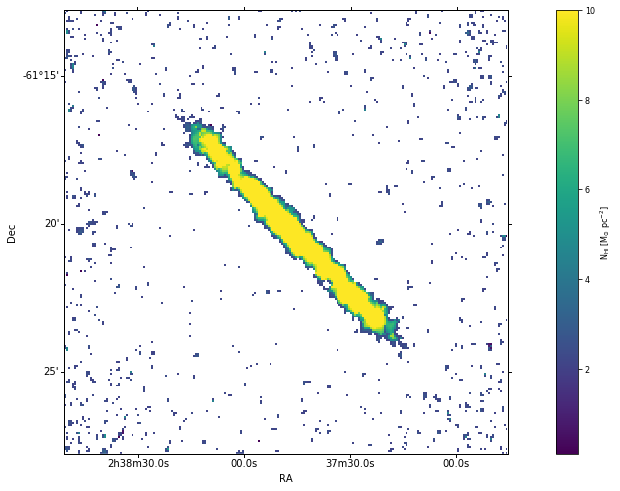

In [107]:
obj = objects[0]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    improve_data(obs_collections[obj], obj, proj, 4.0, 2.0, 
                 'felocity,150,-77,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### ESO138-14
The data are fine and will be  used for the kinematic analysis. 

This is object eso138-g14
['/data/HI_Interferometry/C894/2002-11-29/eso138-g14.uvlin', '/data/HI_Interferometry/C894/2002-11-08/eso138-g14.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 7.0 arcsec.
The beam size is 30.0 by 19.7 arcsec
A third of the minor axis is 6.6
The weighting is 2.0
The line parameter is felocity,150,985,8,8


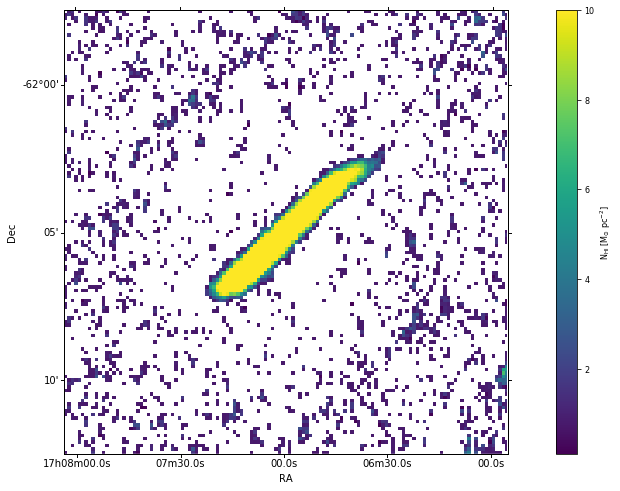

In [108]:
obj = objects[2]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    improve_data(obs_collections[obj], obj, proj, 7.0, 2.0, 
                 'felocity,150,985,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### FGC853
The data are good enough and will be used for the kinematic analysis.

This is object fgc853
['/data/HI_Interferometry/C894/2001-07-28_1/fgc853.uvlin', '/data/HI_Interferometry/C894/2000-05-29_5/fgc853.uvlin', '/data/HI_Interferometry/C894/2000-11-21_2/fgc853.uvlin', '/data/HI_Interferometry/C894/2001-05-05/fgc853.uvlin', '/data/HI_Interferometry/C894/2002-01-14/fgc853.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 14.0 arcsec.
The beam size is 121.6 by 44.0 arcsec
A third of the minor axis is 14.7
The weighting is 2.0
The line parameter is felocity,150,1626,8,8


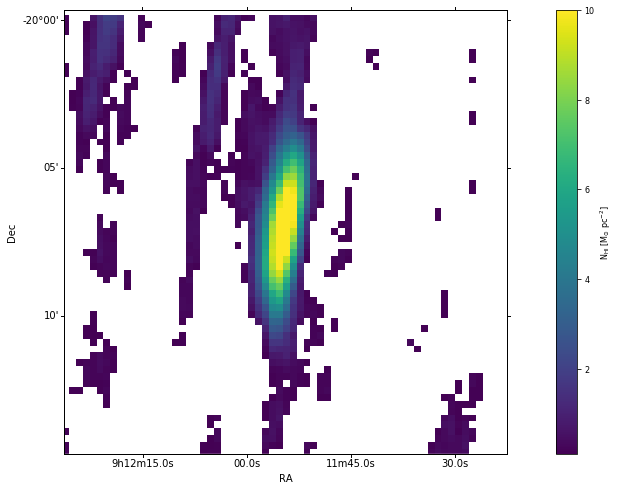

In [109]:
obj = objects[5]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    improve_data(obs_collections[obj], obj, proj, 14.0, 2.0, 
                 'felocity,150,1626,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### FGCE1382
The data are as good as I can get them but not good enough for analysis.

This is object fgce1382
['/data/HI_Interferometry/C894/2001-07-28_2/fgce1382.uvlin', '/data/HI_Interferometry/C894/2002-12-17_1/fgce1382.uvlin', '/data/HI_Interferometry/C894/2002-12-16/fgce1382.uvlin', '/data/HI_Interferometry/C894/2000-11-23_1/fgce1382.uvlin', '/data/HI_Interferometry/C894/2000-11-18_2/fgce1382.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 7.0 arcsec.
The beam size is 24.7 by 21.5 arcsec
A third of the minor axis is 7.2
The weighting is 2.0
The line parameter is felocity,75,1412,16,16


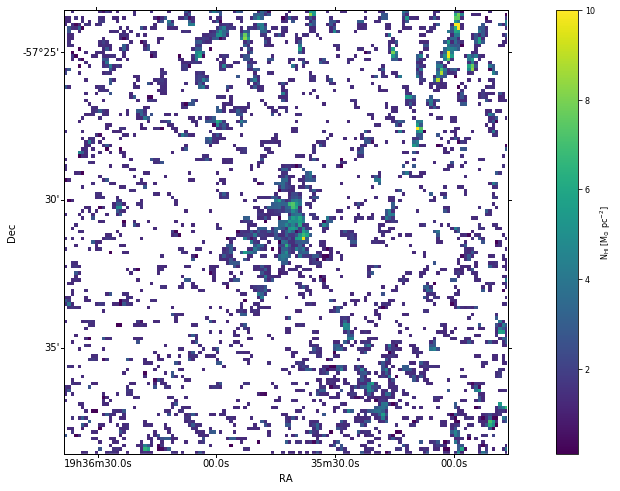

In [110]:
obj = objects[12]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    improve_data(obs_collections[obj], obj, proj, 7.0, 2.0, 
                 'felocity,75,1412,16,16')
cell_size, robust, line = visualise_current(proj, obj)

### FGCE1450
The data are good enough and will be used for the kinematic analysis.

This is object fgce1450
['/data/HI_Interferometry/C894/2001-11-02/fgce1450.uvlin', '/data/HI_Interferometry/C894/2000-05-30_3/fgce1450.uvlin', '/data/HI_Interferometry/C894/2000-05-29_2/fgce1450.uvlin', '/data/HI_Interferometry/C894/2000-11-23_2/fgce1450.uvlin', '/data/HI_Interferometry/C894/2000-11-18_1/fgce1450.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 7.0 arcsec.
The beam size is 60.5 by 20.8 arcsec
A third of the minor axis is 6.9
The weighting is 2.0
The line parameter is felocity,150,2270,8,8


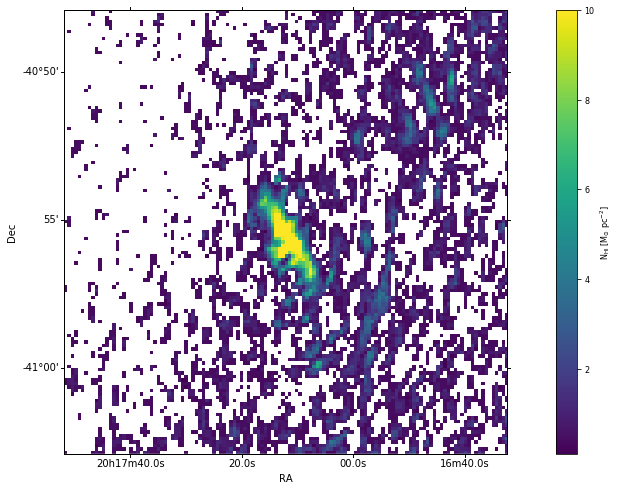

In [111]:
obj = objects[13]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    improve_data(obs_collections[obj], obj, proj, 7.0, 2.0, 
                 'felocity,150,2270,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### FGCE1564
These data will be excluded from the analysis.

### FGCE1709
The data are good and will be used for the kinematic analysis.

This is object fgce1709
['/data/HI_Interferometry/C894/2001-01-11/fgce1709.uvlin', '/data/HI_Interferometry/C894/2000-11-24_3/fgce1709.uvlin', '/data/HI_Interferometry/C894/2002-04-14/fgce1709.uvlin', '/data/HI_Interferometry/C894/2001-07-31/fgce1709.uvlin', '/data/HI_Interferometry/C894/2002-01-27/fgce1709.uvlin', '/data/HI_Interferometry/C894/2000-12-29/fgce1709.uvlin', '/data/HI_Interferometry/C894/2000-12-28_3/fgce1709.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 9.0 arcsec.
The beam size is 37.0 by 26.3 arcsec
A third of the minor axis is 8.8
The weighting is 2.0
The line parameter is felocity,150,985,8,8


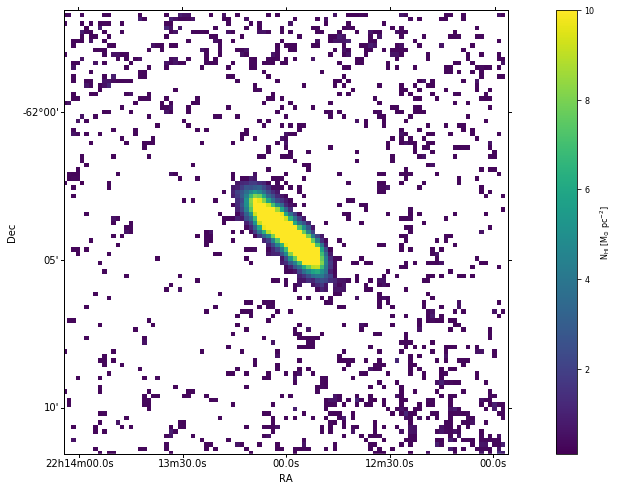

In [112]:
obj = objects[16]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    improve_data(obs_collections[obj], obj, proj, 9.0, 2.0, 
                 'felocity,150,985,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### FGCE749
Something is strange here and the galaxy seems anyway too small for the kinematic analysis.

### FGCE755
The data are not fine and will not be used on the analysis. 

### IC2531
The data are fine and will be used for the kinematic analysis.

This is object ic2531
['/data/HI_Interferometry/C894/2002-01-12/ic2531.uvlin', '/data/HI_Interferometry/C894/2002-01-17_2/ic2531.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 14.0 arcsec.
The beam size is 103.0 by 42.0 arcsec
A third of the minor axis is 14.0
The weighting is 0.5
The line parameter is felocity,150,1841,8,8


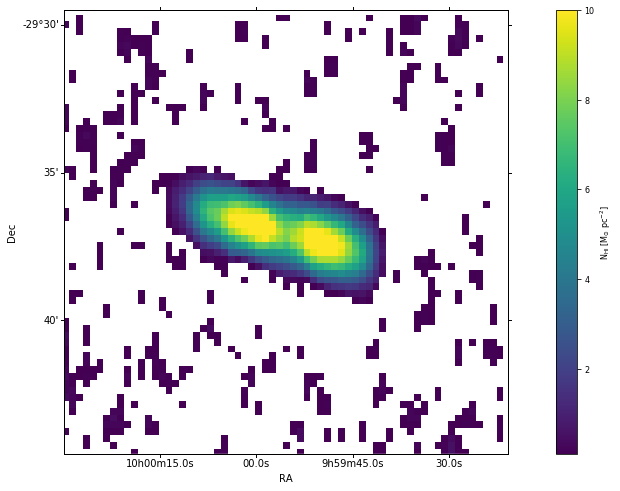

In [113]:
obj = objects[28]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    improve_data(obs_collections[obj], obj, proj, 14.0, 0.5, 
                 'felocity,150,1841,8,8')
cell_size, robust, line = visualise_current(proj, obj)

### IC5249
The data are fine and will be used for the kinematic analysis.

This is object ic5249
['/data/HI_Interferometry/C894/2003-02-03_1/ic5249.uvlin', '/data/HI_Interferometry/C894/2002-12-14/ic5249.uvlin', '/data/HI_Interferometry/C894/2002-11-28_1/ic5249.uvlin']
Now inverting the visibilities...
Now cleaning the dirty cube...
Now creating moment maps and fits files...
The current cell is 8.0 arcsec.
The beam size is 26.2 by 23.7 arcsec
A third of the minor axis is 7.9
The weighting is 2.0
The line parameter is felocity,150,1840,8,8


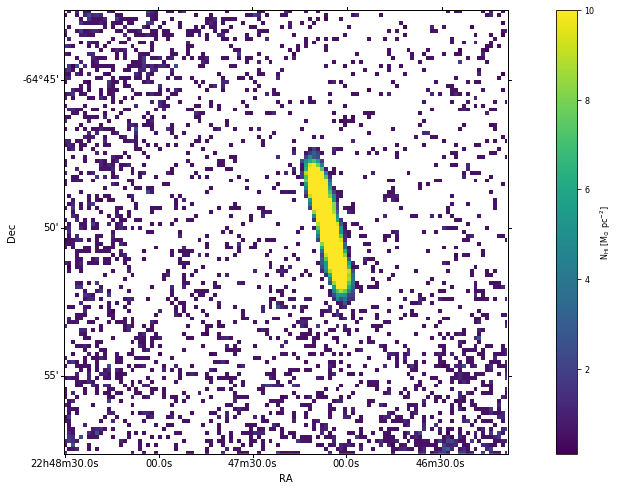

In [114]:
obj = objects[30]
print('This is object {}'.format(obj))
redo_imaging = True
if redo_imaging == True:
    improve_data(obs_collections[obj], obj, proj, 8.0, 2.0, 
                 'felocity,150,1840,8,8')
cell_size, robust, line = visualise_current(proj, obj)